<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

-  [Build_hosp_df](#build_hosp_df).

-  [Build state_cd_df](#build-state_cd_df).

-  [Build week_cdh_df](#build-week_cdh_df).

-  [Build week_cdvh_df](#build-week_cdvh_df).

-  [Build state_cdh_df](#build-state_cdh_df).

-  [Build state_cvdh_df](#build-state_cvdh_df).

-  [Build us_cd_df](#build-us_cd_df).

-  [Build us_cdh_df](#build-us_cdh_df).

-  [Build us_cdvh_df](#build-us_cdvh_df).

-  [Build cumsum-week_cdvh_df](#build_cumsum-week_cdvh_df).



# here #

- Here [Working Here](#working).

MUsic...
Deaths Embracce
The MIrror
TItan's awakening
Dread 

Dark Skies and Other Disasters

Obscura or broken Keys...Intro?

Last Hope...POsitive Vibe
Blood BRothers
Born of a hero
Faction
Skyline +1 FOr TEnsion includes a drop
Fight for after

In Your Face for County timelapse (or tiers)

**John's Hopkins COVID Cases:** https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

**John's Hopkins COVID Deaths:** https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv 

**CDC U.S. Vaccine Data:** https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD

**CDC County Vaccine Data:** https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD

**State Hospitalization Data:** https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

**total_beds_7_day_avg**: Total Bed Capacity to treat people (Is Any Care Available?) Includes pediatrc

**all_adult_hospital_beds_7_day_avg** : All Adult Beds Capacity to treat Adults

**all_adult_hospital_inpatient_beds_7_day_avg**: Available Beds

-999999.0 = Numbers between 1-4 for the week

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as mpatches

import time

from importlib import reload #//*** Reload library reloads an external python File.

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

from datetime import datetime
from pathlib import Path
import os
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import process_covid


plt.style.use('fivethirtyeight')
data_folder_name = "raw_data"

ignore_folder = "anims"
current_dir = Path(os.getcwd()).absolute()
fontsize=20

#//***  Raw and Processed Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename =  "z_us_death_cases.csv"
county_daily_df_filename = "z_county_daily_df.csv.zip"
aggregate_hospital_filename = "z_county_hospital_aggregate.csv.zip"
combined_daily_casevax_filename = "z_county_daily_casevax.csv.zip"
weekly_combined_filename = "z_county_weekly_df.csv.zip"
weekly_combined_historical_filename = "z_county_weekly_case_hosp_df.csv.zip"

#//*** Weekly Combined Cases,Deaths, Vaccines, Hospital
weekly_combined_cdvh_df_filename = "z_county_weekly_combined_cdvh_df.csv.zip"

#//*** Load Raw Hospital Data
#cd.add(process_covid.load_data(filename="z_county_hospital.csv.zip"),'raw_hosp_df',"Raw Unprocessed Hospital Data")

In [2]:
color_dict = {
    'c' : "#00aedb",
    'v' : "#a200ff",
    'd' : "#f47835",
    'h' : "#d41243",
    'i' : "#8ec127",
    'high' : "#4682B4",
    'med' : "#AEA1EA",
    'low' : "#8C54A1"
}

color_dict['low'] = "#3988ff"
color_dict['low'] = "#b468f2"

color_dict['med'] = "#eeb400"
color_dict['high'] = "#a6d298"

color_dict['mean'] = "#ae92c1"

#//*** high old blue: B2EBF9

# Load Dataframe Collection Class #
**Simple Class to keep all Dataframes in a single structure. Each Dataframe has a description to help keep track** 

In [3]:
reload(process_covid)

cd = process_covid.collect_dataframes()

# Load Geopandas Dataframe Shape Files #

In [4]:
reload(process_covid)


#//*** get county shape file
geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df['GEOID'] = geo_df['GEOID'].astype(int)
cd.add(geo_df,"county_geo_df","Geopandas DataFrame: Counties")

#//*** Get Shape File
#geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

geo_df['GEOID'] = geo_df['GEOID'].astype(int)

cd.add(geo_df,"state_geo_df","Geopandas DataFrame: States")


# Load Weekly County Confirmed Death Vax Hospitalizations #
<a id="build-week_cdvh_df"></a> [Top](#top)


In [5]:
reload(process_covid)

#//*****************************************************************************************
#//*** List of Tuples to rename columns.
#//*** This is just a convenience renaming
#//*** In the current version only the sum cols which represent total hospital bed days.
#//*** the avg values are for average daily hospital beds
#//*****************************************************************************************
rename_cols_sum = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

rename_cols_avg = [('total_beds_7_day_avg',"all_bed_types"),
                   ('inpatient_beds_7_day_avg','beds'),
                   ('inpatient_beds_used_7_day_avg','beds_used'),
                   ('inpatient_beds_used_covid_7_day_avg','beds_covid'),
                   ('total_icu_beds_7_day_avg','all_icu'),
                   ('icu_beds_used_7_day_avg','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

#//*** We're bolting on a More efficient Calculate Section. Need to cleanup Download and Process to make it faster and more efficient
remove_cols = ['first_pct','first_ct','case_7_day_avg', 'death_7_day_avg',
       'case_100k_avg', 'death_100k_avg', 'case_scaled_100k',
       'death_scaled_100k', 'pv_tot_confirm', 'pv_tot_death','all_bed_types','Province_State']

#//*****************************************************************************************
#//*** Load the Combined Weekly data of vaccinations, Confirmed, hospitalizations, & Deaths
#//*****************************************************************************************
df = process_covid.load_data(
    filename=weekly_combined_cdvh_df_filename,
     #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = rename_cols_sum,
    remove_cols=remove_cols,
    auto_convert_to_float = True
    )                                      

dfs = []
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'all_bed_types', 'beds', 'beds_used', 'beds_covid', 'all_icu', 'icu_used', 'icu_covid']
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'beds_covid', 'icu_covid','beds', 'beds_used','all_icu', 'icu_used']
display(df.columns)
#//*** Group by FIPS and perform a standard recalc
#//*** This keeps the ccalculations identical across all Aggregation levels
for group in df.groupby("FIPS"):
    #tdf = group[1].copy()[disp_cols]
    tdf = process_covid.standard_recalc_cols(group[1])

    dfs.append(tdf)


cd.add(pd.concat(dfs),'week_cdvh_df','County/Weekly Confirmed, Death,Vaccine, Hospitalization')
df=cd.get('week_cdvh_df')
display(df[df['FIPS'] == 30063])


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid'],
      dtype='object')

Date     FIPS Recip_State  vax_pct   vax_ct       cty  \
218  2020-12-18  30063.0          MT      0.0      0.0  Missoula   
160  2020-12-25  30063.0          MT      0.0      0.0  Missoula   
854  2021-01-01  30063.0          MT      0.0      0.0  Missoula   
1894 2021-01-08  30063.0          MT      0.0      0.0  Missoula   
1579 2021-01-15  30063.0          MT      1.4   1725.0  Missoula   
524  2021-01-22  30063.0          MT      2.0   2395.0  Missoula   
1916 2021-01-29  30063.0          MT      3.0   3571.0  Missoula   
1333 2021-02-05  30063.0          MT      3.6   4287.0  Missoula   
1048 2021-02-12  30063.0          MT      4.7   5672.0  Missoula   
1612 2021-02-19  30063.0          MT      6.8   8102.0  Missoula   
567  2021-02-26  30063.0          MT      9.1  10847.0  Missoula   
2358 2021-03-05  30063.0          MT     10.7  12825.0  Missoula   
116  2021-03-12  30063.0          MT     13.6  16312.0  Missoula   
322  2021-03-19  30063.0          MT     15.4  18426.0  Missoula   
935  2021-03-26  30063.0          MT     17.2  20622.0  Missoula   
2063 2021-04-02  30063.0          MT     20.4  24370.0  Missoula   
402  2021-04-09  30063.0          MT     25.6  30636.0  Missoula   
2360 2021-04-16  30063.0          MT     31.2  37302.0  Missoula   
673  2021-04-23  30063.0          MT     36.7  43914.0  Missoula   
511  2021-04-30  30063.0          MT     41.2  49251.0  Missoula   
14   2021-05-07  30063.0          MT     43.7  52323.0  Missoula   
2041 2021-05-14  30063.0          MT     45.5  54402.0  Missoula   
1032 2021-05-21  30063.0          MT     47.2  56445.0  Missoula   
510  2021-05-28  30063.0          MT     48.8  58345.0  Missoula   
434  2021-06-04  30063.0          MT     49.1  58724.0  Missoula   
497  2021-06-11  30063.0          MT     50.8  60777.0  Missoula   
2254 2021-06-18  30063.0          MT     52.1  62299.0  Missoula   
296  2021-06-25  30063.0          MT     52.5  62750.0  Missoula   
424  2021-07-02  30063.0          MT     53.1  63458.0  Missoula   
1897 2021-07-09  30063.0          MT     53.3  63767.0  Missoula   
88   2021-07-16  30063.0          MT     53.6  64047.0  Missoula   
1658 2021-07-23  30063.0          MT     53.8  64324.0  Missoula   
1271 2021-07-30  30063.0          MT     54.0  64603.0  Missoula   
1349 2021-08-06  30063.0          MT     54.3  64896.0  Missoula   
1230 2021-08-13  30063.0          MT     54.6  65290.0  Missoula   
1509 2021-08-20  30063.0          MT     55.0  65747.0  Missoula   
925  2021-08-27  30063.0          MT     55.4  66273.0  Missoula   
2301 2021-09-03  30063.0          MT     55.8  66784.0  Missoula   
759  2021-09-10  30063.0          MT     56.2  67268.0  Missoula   
2062 2021-09-17  30063.0          MT     56.6  67747.0  Missoula   
2223 2021-09-24  30063.0          MT     57.0  68144.0  Missoula   
1270 2021-10-01  30063.0          MT     57.2  68451.0  Missoula   
808  2021-10-08  30063.0          MT     57.6  68891.0  Missoula   
1670 2021-10-15  30063.0          MT     57.9  69200.0  Missoula   
1836 2021-10-22  30063.0          MT     58.3  69673.0  Missoula   
1617 2021-10-29  30063.0          MT     58.6  70104.0  Missoula   
337  2021-11-05  30063.0          MT     58.8  70362.0  Missoula   
935  2021-11-12  30063.0          MT     59.0  70592.0  Missoula   
164  2021-11-19  30063.0          MT     59.3  70970.0  Missoula   
1214 2021-11-26  30063.0          MT     59.5  71132.0  Missoula   
1673 2021-12-03  30063.0          MT     59.9  71581.0  Missoula   
1084 2021-12-10  30063.0          MT     61.1  73060.0  Missoula   
1979 2021-12-17  30063.0          MT     62.0  74120.0  Missoula   
1391 2021-12-24  30063.0          MT     62.2  74432.0  Missoula   
1402 2021-12-31  30063.0          MT     62.3  74570.0  Missoula   
2215 2022-01-07  30063.0          MT     62.5  74787.0  Missoula   
882  2022-01-14  30063.0          MT     62.8  75106.0  Missoula   
1259 2022-01-21  30063.0          MT     63.1  75500.0  Missoula   

# Load Daily County Cases and Deaths #

In [6]:
cd.add(process_covid.load_data(filename=county_daily_df_filename,remove_cols=['case_7_day_avg','death_7_day_avg','case_100k_avg','death_100k_avg','case_scaled_100k','death_scaled_100k']),'county_daily_df',"County/Daily Cases and Deaths")





# Load Weekly County Hospitalizations # 

<a id="build_hosp_df"></a> [Top](#top)


In [7]:
#//****************************************************************************************
#//*** Load aggregated (summed by county) Hospital Data, provides cleanest cumsum values
#//****************************************************************************************
df = process_covid.load_data(
    filename=aggregate_hospital_filename,
    #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('collection_week',"Date"),
                  ])
df['Date'] = pd.to_datetime(df['Date'])
df = process_covid.cumsum_cols(df,cols=['beds_covid','icu_covid'], by='fips_code', date_col="Date", suffix="_tot")
cd.add(df,'hosp_df',"County/Weekly Hospitalization Data")
display(df.head())

Date fips_code state all_bed_types    beds beds_used beds_covid  \
0 2020-07-31    1001.0    AL         574.0   455.0     363.0      119.0   
1 2020-07-31   18093.0    IN         497.0   497.0     150.0       44.0   
2 2020-07-31   31185.0    NE          91.0    91.0      13.0        6.0   
3 2020-07-31   32001.0    NV         287.0   175.0     120.0       32.0   
4 2020-07-31   18091.0    IN        1596.0  1407.0    1023.0       68.0   

  all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
0    42.0     40.0      28.0          119.0          28.0  
1    44.0     27.0       0.0           44.0           0.0  
2     0.0      0.0       0.0            6.0           0.0  
3    28.0     17.0       8.0           32.0           8.0  
4   196.0    137.0      43.0           68.0          43.0

# Build: Weekly Confirm Death Hospitalization #
<a id="build-week_cdh_df"></a> [Top](#top)

Hospitalizations without Vaccines provides 5 months of additional hospitalization data

In [8]:
reload(process_covid)
#//*** Build Weekly Case Death & Hospital

    
dates =  cd.get('hosp_df')['Date'].unique()

#print(dates)

#//*** Get Weekly Values
df = cd.get('county_daily_df')
df['Date'] = df['Date'].apply(lambda x: pd.Timestamp(x))
dates = cd.get('hosp_df')['Date'].apply(lambda x: pd.Timestamp(x))

#//*** Soo Slick. Select dates from a unique list of dates in hospital
df = df [ df['Date'].isin(dates)]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="FIPS",suffix="")
#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="FIPS",suffix="_tot")

#//*** Combine Weekly Valuess with Hospital
df = process_covid.merge_df(df,cd.get('hosp_df'),left_col="FIPS",right_col="fips_code")

#//*** Rename Population Column to pop
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

display(df)
display(df [df["FIPS"] == 1003].iloc[:10])

#//*** Load Weekly Case Death Hospital
cd.add(df,'week_cdh_df','County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08')


Elapsed Time: 0s


Date   FIPS       Admin2 Province_State              Combined_Key  \
0    2020-07-31   1001      Autauga        Alabama      Autauga, Alabama, US   
1    2020-07-31  40073   Kingfisher       Oklahoma  Kingfisher, Oklahoma, US   
2    2020-07-31  40075        Kiowa       Oklahoma       Kiowa, Oklahoma, US   
3    2020-07-31   6025     Imperial     California  Imperial, California, US   
4    2020-07-31  40079     Le Flore       Oklahoma    Le Flore, Oklahoma, US   
...         ...    ...          ...            ...                       ...   
2428 2022-05-06  42085       Mercer   Pennsylvania  Mercer, Pennsylvania, US   
2429 2022-05-06  48127       Dimmit          Texas         Dimmit, Texas, US   
2430 2022-05-06  19033  Cerro Gordo           Iowa     Cerro Gordo, Iowa, US   
2431 2022-05-06  12086   Miami-Dade        Florida   Miami-Dade, Florida, US   
2432 2022-05-06   5001     Arkansas       Arkansas    Arkansas, Arkansas, US   

          pop  tot_confirm  tot_deaths  New_Confirm  New_Deaths  \
0       55869         1042          20          0.0         0.0   
1       15765          101           0          0.0         0.0   
2        8708           24           1          0.0         0.0   
3      181215         7893         155          0.0         0.0   
4       49853          218           1          0.0         0.0   
...       ...          ...         ...          ...         ...   
2428   109424        23500         498         51.0         2.0   
2429    10124         5757          51          1.0         0.0   
2430    42450        11140         169         17.0         0.0   
2431  2716940      1216226       10917      16502.0        22.0   
2432    17486         5690          79          8.0         0.0   

      New_Confirm_tot  New_Deaths_tot fips_code state all_bed_types     beds  \
0                 0.0             0.0    1001.0    AL         574.0    455.0   
1                 0.0             0.0   40073.0    OK         651.0    651.0   
2                 0.0             0.0   40075.0    OK         233.0     95.0   
3                 0.0             0.0    6025.0    CA        1774.0   1402.0   
4                 0.0             0.0   40079.0    OK          81.0      0.0   
...               ...             ...       ...   ...           ...      ...   
2428          23171.0           489.0   42085.0    PA        1485.0   2016.0   
2429           5651.0            50.0   48127.0    TX         249.0    207.0   
2430          10568.0           152.0   19033.0    IA        1827.0   1295.0   
2431        1097764.0          9306.0   12086.0    FL       34945.0  46889.0   
2432           5501.0            78.0    5001.0    AR        1939.0   2149.0   

     beds_used beds_covid all_icu icu_used icu_covid beds_covid_tot  \
0        363.0      119.0    42.0     40.0      28.0          119.0   
1         55.0        0.0     0.0      0.0       0.0            0.0   
2         31.0        1.0     0.0      0.0       0.0            1.0   
3       1010.0      372.0   206.0    181.0     129.0          372.0   
4          0.0       90.0     0.0      0.0       0.0           90.0   
...        ...        ...     ...      ...       ...            ...   
2428     813.0       17.0   231.0    115.0       1.0        13402.0   
2429      91.0        0.0    14.0      0.0       0.0         1749.0   
2430     847.0       26.0   126.0     87.0       0.0        11938.0   
2431   35449.0     1809.0  8767.0   5739.0     166.0       508505.0   
2432    1342.0       28.0   252.0    225.0       7.0        20381.0   

     icu_covid_tot  
0             28.0  
1              0.0  
2              0.0  
3            129.0  
4              0.0  
...            ...  
2428        2745.0  
2429          10.0  
2430        2683.0  
2431      109028.0  
2432        6876.0  

[226243 rows x 23 columns]

Date  FIPS   Admin2 Province_State          Combined_Key     pop  \
2355 2020-07-31  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1886 2020-08-07  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
679  2020-08-14  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1616 2020-08-21  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
416  2020-08-28  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1274 2020-09-04  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1277 2020-09-11  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1604 2020-09-18  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
743  2020-09-25  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
117  2020-10-02  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   

      tot_confirm  tot_deaths  New_Confirm  New_Deaths  New_Confirm_tot  \
2355         3116          21          0.0         0.0              0.0   
1886         3533          23        417.0         2.0            417.0   
679          3881          29        348.0         6.0            765.0   
1616         4100          32        219.0         3.0            984.0   
416          4408          35        308.0         3.0           1292.0   
1274         4654          42        246.0         7.0           1538.0   
1277         4881          43        227.0         1.0           1765.0   
1604         5016          48        135.0         5.0           1900.0   
743          5419          50        403.0         2.0           2303.0   
117          6009          53        590.0         3.0           2893.0   

      New_Deaths_tot fips_code state all_bed_types    beds beds_used  \
2355             0.0    1003.0    AL        2961.0  2541.0    2140.0   
1886             2.0    1003.0    AL        2961.0  2541.0    2136.0   
679              8.0    1003.0    AL        2961.0  2541.0    2078.0   
1616            11.0    1003.0    AL        2961.0  2541.0    2041.0   
416             14.0    1003.0    AL        2961.0  2541.0    1949.0   
1274            21.0    1003.0    AL        2961.0  2541.0    1903.0   
1277            22.0    1003.0    AL        2753.0  2359.0    1677.0   
1604            27.0    1003.0    AL        2961.0  2541.0    2061.0   
743             29.0    1003.0    AL        2961.0  2541.0    1884.0   
117             32.0    1003.0    AL        2961.0  2541.0    1961.0   

     beds_covid all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
2355      487.0   224.0    263.0     153.0          487.0         153.0  
1886      488.0   224.0    276.0     142.0          975.0         295.0  
679       422.0   224.0    250.0     106.0         1397.0         401.0  
1616      313.0   224.0    252.0      91.0         1710.0         492.0  
416       263.0   224.0    215.0      65.0         1973.0         557.0  
1274      185.0   224.0    210.0      50.0         2158.0         607.0  
1277      148.0   207.0    174.0      39.0         2306.0         646.0  
1604      194.0   224.0    198.0      49.0         2500.0         695.0  
743       198.0   224.0    182.0      47.0         2698.0         742.0  
117       162.0   224.0    175.0      41.0         2860.0         783.0

In [9]:
cd.l()

Collected Dataframe Count:  6
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08


# Daily Confirmed Deaths: States #
<a id="build-state_cd_df"></a> [Top](#top)


In [10]:
reload(process_covid)

df = cd.get('county_daily_df')
display(df)
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

sum_cols = ['pop','tot_confirm','tot_deaths']

state_list = []
for state_group in df.groupby("Province_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[2:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        build_100k = False,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]

        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr

        #],
    )
    state_list.append(loop_df)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")
#//*** Build confirm and death running totals
#df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

cd.add(df,'state_cd_df',"State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]")

df = cd.get('state_cd_df')
df[df['state'] == "California"].iloc[50:100]


Date   FIPS     Admin2 Province_State              Combined_Key  \
7   2020-01-29   1001    Autauga        Alabama      Autauga, Alabama, US   
8   2020-01-30   1001    Autauga        Alabama      Autauga, Alabama, US   
9   2020-01-31   1001    Autauga        Alabama      Autauga, Alabama, US   
10  2020-02-01   1001    Autauga        Alabama      Autauga, Alabama, US   
11  2020-02-02   1001    Autauga        Alabama      Autauga, Alabama, US   
..         ...    ...        ...            ...                       ...   
835 2022-05-06  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
836 2022-05-07  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
837 2022-05-08  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
838 2022-05-09  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
839 2022-05-10  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   

     Population  tot_confirm  tot_deaths  New_Confirm  New_Deaths  
7         55869            0           0          0.0         0.0  
8         55869            0           0          0.0         0.0  
9         55869            0           0          0.0         0.0  
10        55869            0           0          0.0         0.0  
11        55869            0           0          0.0         0.0  
..          ...          ...         ...          ...         ...  
835           0        48746         272          0.0         0.0  
836           0        48746         272          0.0         0.0  
837           0        48746         272          0.0         0.0  
838           0        48746         272          0.0         0.0  
839           0        48746         272          0.0         0.0  

[2639591 rows x 10 columns]

Date       state       pop  tot_confirm  tot_deaths  New_Confirm  \
2581 2020-03-19  California  39512223          983          20        190.0   
2614 2020-03-20  California  39512223         1244          23        261.0   
2699 2020-03-21  California  39512223         1396          26        152.0   
2706 2020-03-22  California  39512223         1697          36        301.0   
2775 2020-03-23  California  39512223         2073          40        376.0   
2826 2020-03-24  California  39512223         2501          51        428.0   
2888 2020-03-25  California  39512223         3013          66        512.0   
2935 2020-03-26  California  39512223         3879          80        866.0   
2959 2020-03-27  California  39512223         4537         100        658.0   
3018 2020-03-28  California  39512223         7514         188       2977.0   
3069 2020-03-29  California  39512223         5495         132      -2019.0   
3146 2020-03-30  California  39512223         6864         149       1369.0   
3201 2020-03-31  California  39512223         8011         170       1147.0   
3217 2020-04-01  California  39512223         9266         198       1255.0   
3299 2020-04-02  California  39512223        10765         236       1499.0   
3355 2020-04-03  California  39512223        12089         273       1324.0   
3373 2020-04-04  California  39512223        12835         292        746.0   
3464 2020-04-05  California  39512223        14490         342       1655.0   
3493 2020-04-06  California  39512223        15957         371       1467.0   
3557 2020-04-07  California  39512223        17055         424       1098.0   
3611 2020-04-08  California  39512223        18410         485       1355.0   
3627 2020-04-09  California  39512223        19533         537       1123.0   
3718 2020-04-10  California  39512223        20749         577       1216.0   
3773 2020-04-11  California  39512223        21458         599        709.0   
3792 2020-04-12  California  39512223        22197         632        739.0   
3857 2020-04-13  California  39512223        23407         696       1210.0   
3906 2020-04-14  California  39512223        24545         781       1138.0   
3949 2020-04-15  California  39512223        26357         873       1812.0   
3979 2020-04-16  California  39512223        27579         955       1222.0   
4044 2020-04-17  California  39512223        29297        1023       1718.0   
4107 2020-04-18  California  39512223        30643        1127       1346.0   
4158 2020-04-19  California  39512223        31308        1159        665.0   
4223 2020-04-20  California  39512223        33563        1199       2255.0   
4271 2020-04-21  California  39512223        35754        1287       2191.0   
4325 2020-04-22  California  39512223        37749        1412       1995.0   
4375 2020-04-23  California  39512223        39597        1502       1848.0   
4392 2020-04-24  California  39512223        41467        1585       1870.0   
4460 2020-04-25  California  39512223        42433        1660        966.0   
4516 2020-04-26  California  39512223        43736        1692       1303.0   
4546 2020-04-27  California  39512223        45314        1732       1578.0   
4617 2020-04-28  California  39512223        46829        1827       1515.0   
4677 2020-04-29  California  39512223        49226        1910       2397.0   
4723 2020-04-30  California  39512223        50715        1999       1489.0   
4743 2020-05-01  California  39512223        52549        2095       1834.0   
4836 2020-05-02  California  39512223        53887        2157       1338.0   
4876 2020-05-03  California  39512223        55254        2199       1367.0   
4925 2020-05-04  California  39512223        56614        2244       1360.0   
4983 2020-05-05  California  39512223        59202        2357       2588.0   
5048 2020-05-06  California  39512223        61081        2441       1879.0   
5079 2020-05-07  California  39512223        63006        251

In [11]:
# Add GeoPandas State and County Levels

In [12]:
cd.l()


Collected Dataframe Count:  7
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]


# Weekly Confirmed Deaths Hospitalization: States #

<a id="build-state_cdh_df"></a> [Top](#top)


In [13]:

reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','icu_used']

state_list = []
for state_group in cd.get('week_cdh_df').groupby("Province_State"):
    #display(state_group[1])
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,

    )
    state_list.append(loop_df)


          
df = pd.concat(state_list)

df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
cd.add(df,'state_cdh_df','State Weekly Cases Deaths Hospitals')
df = cd.get('state_cdh_df')
df[df['state'] == "California"]


Date       state       pop  tot_confirm  tot_deaths beds_covid  \
37   2020-07-31  California  39508089       506935        9122    51626.0   
88   2020-08-07  California  39508089       553699       10019    46828.0   
105  2020-08-14  California  39508089       619800       11012    43542.0   
162  2020-08-21  California  39508089       662856       11802    38523.0   
242  2020-08-28  California  39508089       699731       12638    33135.0   
268  2020-09-04  California  39508089       733226       13501    28397.0   
310  2020-09-11  California  39479696       756007       14115    24890.0   
399  2020-09-18  California  39508089       780952       14825    22915.0   
431  2020-09-25  California  39508089       805718       15391    21865.0   
483  2020-10-02  California  39479696       828540       15971    20989.0   
535  2020-10-09  California  39508089       853032       16400    21339.0   
599  2020-10-16  California  39445281       874305       16814    20868.0   
628  2020-10-23  California  39508089       905203       17231    20980.0   
686  2020-10-30  California  39508089       935585       17569    23250.0   
715  2020-11-06  California  39508089       973301       17913    26599.0   
768  2020-11-13  California  39479696      1027187       18202    34002.0   
854  2020-11-20  California  39479696      1112478       18651    45850.0   
903  2020-11-27  California  39508089      1214179       19131    61840.0   
928  2020-12-04  California  39508089      1355265       19798    79811.0   
995  2020-12-11  California  39508089      1579209       20822   106069.0   
1047 2020-12-18  California  39508089      1876451       22373   130459.0   
1116 2020-12-25  California  39508089      2147716       23916   144780.0   
1146 2021-01-01  California  39508089      2435496       26258   153920.0   
1219 2021-01-08  California  39508089      2728938       29069   164061.0   
1233 2021-01-15  California  39508089      3015244       32390   144226.0   
1295 2021-01-22  California  39508089      3204750       35664   124903.0   
1369 2021-01-29  California  39508089      3348577       39438   102809.0   
1416 2021-02-05  California  39508089      3452229       43124    82782.0   
1445 2021-02-12  California  39508089      3527852       46044    63127.0   
1510 2021-02-19  California  39508089      3577416       48528    48102.0   
1532 2021-02-26  California  39508089      3618404       51727    36563.0   
1587 2021-03-05  California  39508089      3650297       53660    28620.0   
1678 2021-03-12  California  39508089      3677416       55166    24557.0   
1726 2021-03-19  California  39508089      3696678       56217    20666.0   
1758 2021-03-26  California  39508089      3715767       57770    18053.0   
1791 2021-04-02  California  39508089      3735875       58706    16130.0   
1845 2021-04-09  California  39508089      3755367       59383    14918.0   
1911 2021-04-16  California  39508089      3776334       59950    14609.0   
1987 2021-04-23  California  39508089      3791089       60410    14339.0   
2027 2021-04-30  California  39508089      3805109       60876    13191.0   
2062 2021-05-07  California  39508089      3818774       61305    12346.0   
2120 2021-05-14  California  39508089      3830393       61533    11388.0   
2187 2021-05-21  California  39508089      3839442       61796    10044.0   
2193 2021-05-28  California  39508089      3852141       62099     9229.0   
2268 2021-06-04  California  39508089      3858544       62330     8932.0   
2315 2021-06-11  California  39508089      3865873       62590     8403.0   
2372 2021-06-18  California  39508089      3872428       62693     8385.0   
2401 2021-06-25  California  39508089      3881728       62979     8632.0   
2453 2021-07-02  California  39508089      3886715       63186    10093.0   
2537 2021-07-09  California  39508089      3899451       63418    12780.0   
2553 2021-07-16  California  39508089      3926051       63642    17168.0   
2604 20

In [14]:
cd.get('week_cdvh_df')

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
1634 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
1986 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
1469 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
97   2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
133  2022-04-08  56045.0          WY     37.8  2619.0   Weston   
1521 2022-04-15  56045.0          WY     37.8  2621.0   Weston   
138  2022-04-22  56045.0          WY     37.9  2622.0   Weston   
2042 2022-04-29  56045.0          WY     37.9  2627.0   Weston   
2422 2022-05-06  56045.0          WY     38.0  2632.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
1634  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
1986  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
1469  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
97    Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
133    Weston, Wyoming, US   6927.0       1588.0        18.0          0.0   
1521   Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
138    Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   
2042   Weston, Wyoming, US   6927.0       1588.0        18.0          1.0   
2422   Weston, Wyoming, US   6927.0       1589.0        18.0          1.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
1634         2.0    AL  462.0      445.0       286.0     42.0      42.0   
1986         4.0    AL  462.0      454.0       282.0     42.0      42.0   
1469         0.0    AL  462.0      431.0       291.0     42.0      42.0   
97           5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
133          0.0    WY   84.0       34.0         0.0      0.0       0.0   
1521         0.0    WY   84.0       23.0         0.0      0.0       0.0   
138          0.0    WY   84.0       21.0         0.0      0.0       0.0   
2042         0.0    WY   84.0       22.0         0.0      0.0       0.0   
2422         0.0    WY   84.0       19.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
1634       27.0               343.0                2.0           506.0   
1986       29.0               592.0                6.0           788.0   
1469       38.0              1123.0                6.0          1079.0   
97         39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
133         0.0              1145.0               16.0           196.0   
1521        0.0              1144.0               16.0           196.0   
138         0.0              1144.0               16.0           196.0   
2042        0.0              1145.0               16.0           196.0   
2422        0.0              1146.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
1634           54.0     924.0          870.0         84.0          81.0   
1986           83.0    1386.0         1324.0        126.0         123.0   
1469          121.0    1848.0         1755.0        168.0         165.0   
97            160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

# Build State Totals For Vaccine Outcome Ratios #
# Build: state_ratios_df #

<a id="build-state_cvdh_df"></a> [Top](#top)


In [15]:
reload(process_covid)

#sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    
    
    tdf = process_covid.standard_recalc_cols(tdf)
    
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)
df['state'] = process_covid.rename_state_abbreviations(df['state'])
for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])


Collected Dataframe Count:  9
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals


None

Date       state         pop      vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18  California  39508089.0         0.0    1876451.0     22373.0   
1  2020-12-25  California  39508089.0        94.0    2147716.0     23916.0   
2  2021-01-01  California  39508089.0       476.0    2435496.0     26258.0   
3  2021-01-08  California  39508089.0     17255.0    2728938.0     29069.0   
4  2021-01-15  California  39508089.0    207791.0    3015244.0     32390.0   
5  2021-01-22  California  39508089.0    332836.0    3204750.0     35664.0   
6  2021-01-29  California  39508089.0    500510.0    3348577.0     39438.0   
7  2021-02-05  California  39508089.0    712410.0    3452229.0     43124.0   
8  2021-02-12  California  39508089.0   1107270.0    3527852.0     46044.0   
9  2021-02-19  California  39508089.0   1785911.0    3577416.0     48528.0   
10 2021-02-26  California  39508089.0   2412254.0    3618404.0     51727.0   
11 2021-03-05  California  39508089.0   3056886.0    3650297.0     53660.0   
12 2021-03-12  California  39508089.0   3616673.0    3677416.0     55166.0   
13 2021-03-19  California  39508089.0   4568213.0    3696678.0     56217.0   
14 2021-03-26  California  39508089.0   5591004.0    3715767.0     57770.0   
15 2021-04-02  California  39508089.0   6614328.0    3735875.0     58706.0   
16 2021-04-09  California  39508089.0   7843558.0    3755367.0     59383.0   
17 2021-04-16  California  39508089.0   9327853.0    3776334.0     59950.0   
18 2021-04-23  California  39508089.0  10522790.0    3791089.0     60410.0   
19 2021-04-30  California  39508089.0  11760950.0    3805109.0     60876.0   
20 2021-05-07  California  39508089.0  13118973.0    3818774.0     61305.0   
21 2021-05-14  California  39508089.0  14527325.0    3830393.0     61533.0   
22 2021-05-21  California  39508089.0  15581551.0    3839442.0     61796.0   
23 2021-05-28  California  39508089.0  16447794.0    3852141.0     62099.0   
24 2021-06-04  California  39508089.0  16955557.0    3858544.0     62330.0   
25 2021-06-11  California  39508089.0  17827509.0    3865873.0     62590.0   
26 2021-06-18  California  39508089.0  18524237.0    3872428.0     62693.0   
27 2021-06-25  California  39508089.0  18932475.0    3881728.0     62979.0   
28 2021-07-02  California  39508089.0  19308340.0    3886715.0     63186.0   
29 2021-07-09  California  39508089.0  19575401.0    3899451.0     63418.0   
30 2021-07-16  California  39508089.0  19830357.0    3926051.0     63642.0   
31 2021-07-23  California  39508089.0  20067152.0    3966708.0     63791.0   
32 2021-07-30  California  39508089.0  20290748.0    4028401.0     63984.0   
33 2021-08-06  California  39508089.0  20557963.0    4115493.0     64312.0   
34 2021-08-13  California  39508089.0  20788949.0    4203483.0     64185.0   
35 2021-08-20  California  39508089.0  21056084.0    4310799.0     64639.0   
36 2021-08-27  California  39508089.0  21348996.0    4405986.0     65210.0   
37 2021-09-03  California  39508089.0  21650618.0    4505954.0     65938.0   
38 2021-09-10  California  39508089.0  21864015.0    4577004.0     66733.0   
39 2021-09-17  California  39508089.0  22188161.0    4645220.0     67609.0   
40 2021-09-24  California  39508089.0  22502934.0    4693551.0     68278.0   
41 2021-10-01  California  39508089.0  22692299.0    4745823.0     68960.0   
42 2021-10-08  California  39508089.0  22935603.0    4788472.0     69705.0   
43 2021-10-15  California  39508089.0  23126408.0    4826955.0     70323.0   
44 2021-10-22  California  39508089.0  23329358.0    4866053.0     71274.0   
45 2021-10-29  California  39508089.0  23511387.0    4909272.0     71898.0   
46 2021-11-05  California  39508089.0  23695417.0    4953211.0     72431.0   
47 2021-11-12  California  39508089.0  23892745.0    4996622.0     72965.0   
48 2021-11-19  California  39508089.0  24060522.0    5029681.0     73644.0   
49 2021-11-26  California  39508089.0  24165411.0    5055530.0     74091.0   
50 2021-12-03  California  3950

In [16]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

#//*** Build Hospital Post Vax Totals
df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)

#print(df['beds_covid_tot'].min(),df['beds_covid_tot'].iloc[0])
#df['pv_beds_covid_tot'] = (df['beds_covid_tot'] - 130459)
#df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]


df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm','tot_deaths','beds_covid_tot', 'icu_covid_tot','New_Confirm','New_Deaths','pv_New_Confirm_tot','pv_New_Deaths_tot','pv_beds_covid_tot','pv_icu_covid_tot'])

for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
    

df['state'] = process_covid.rename_state_abbreviations(df['state'])


cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])

"""

'\nreload(process_covid)\n\nsum_cols = [\'pop\',\'vax_ct\',\'tot_confirm\',\'tot_deaths\',\'beds_covid\',\'icu_covid\',\'beds_covid_tot\',\'icu_covid_tot\']\nstate_list = []\nfor state_group in cd.get(\'week_cdvh_df\').groupby("Recip_State"):\n    #//*** Build a DF for each State Aggregating the State Totals\n    #//*** Sum all Counties by Date\n    #//*** Sum columns listed in sum_cols\n    tdf =  process_covid.build_stats_for_analysis(  \n        state_group[1], #//*** DF of CA results\n        action=\'agg_cols\',     #//*** Agggregate Columns\n        cols=sum_cols,         #//*** List of Columns to Aggregate\n        agg=\'sum\',             #//*** Aggregation Action: Sum\n        label=(\'state\',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple (\'column name\',\'value\')\n        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: \'beds_covid\',\'icu_covid\',\'beds\',\'icu_used\'\n        #build_100k = True,\n        verbose = False,\n      

# Build Daily Confirmed Deaths: United States #

<a id="build-us_cd_df"></a> [Top](#top)


In [17]:
reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cd_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

df = process_covid.build_100k(df, cols=list(df.columns)[2:])

display(df)

cd.add(df,'us_cd_df',"United States/Daily Confirmed Death ")



Date state        pop  tot_confirm  tot_deaths  New_Confirm  \
0   2020-01-29    US  328248973            6           1          0.0   
1   2020-01-30    US  328248973            6           1          0.0   
2   2020-01-31    US  328248973            8           1          2.0   
3   2020-02-01    US  328248973            8           1          0.0   
4   2020-02-02    US  328248973            8           1          0.0   
..         ...   ...        ...          ...         ...          ...   
834 2022-05-12    US  328248973     80825596      984636      92452.0   
835 2022-05-13    US  328248973     80912471      984981      86875.0   
836 2022-05-14    US  328248973     80921562      985009       9091.0   
837 2022-05-15    US  328248973     80945806      985039      24244.0   
838 2022-05-16    US  328248973     81070803      985298     124997.0   

     New_Deaths  pop_100k  tot_confirm_100k  tot_deaths_100k  \
0           0.0    100000                 0                0   
1           0.0    100000                 0                0   
2           0.0    100000                 0                0   
3           0.0    100000                 0                0   
4           0.0    100000                 0                0   
..          ...       ...               ...              ...   
834        31.0    100000             24623              299   
835       345.0    100000             24649              300   
836        28.0    100000             24652              300   
837        30.0    100000             24659              300   
838       259.0    100000             24697              300   

     New_Confirm_100k  New_Deaths_100k  
0                   0                0  
1                   0                0  
2                   0                0  
3                   0                0  
4                   0                0  
..                ...              ...  
834                28                0  
835                26                0  
836                 2                0  
837                 7                0  
838                38                0  

[839 rows x 12 columns]

# Weekly Confirmed Deaths Hospitalization: United States #
<a id="build-us_cdh_df"></a> [Top](#top)


In [18]:
reload(process_covid)


sum_cols = ['pop','tot_confirm','tot_deaths','New_Confirm', 'New_Deaths','beds_covid','icu_covid','beds','icu_used']
state_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
tdf =  process_covid.build_stats_for_analysis(  
    cd.get('state_cdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
 )

cd.add(tdf,'us_cdh_df','United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08')

# Weekly Confirmed Deaths Vax Hospitalization: United States #

<a id="build-us_cdvh_df"></a> [Top](#top)


In [19]:
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
df = process_covid.standard_recalc_cols(df)

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")

Date state          pop       vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18    US  314857069.0          0.0   16627747.0    301060.0   
1  2020-12-25    US  314872985.0        464.0   17917543.0    317557.0   
2  2021-01-01    US  314872985.0       4355.0   19283869.0    334789.0   
3  2021-01-08    US  314836721.0     196733.0   20932621.0    355223.0   
4  2021-01-15    US  314836721.0    1264054.0   22469073.0    377221.0   
5  2021-01-22    US  314836721.0    2227662.0   23672547.0    397901.0   
6  2021-01-29    US  314836721.0    3867740.0   24702609.0    419330.0   
7  2021-02-05    US  314814597.0    6131952.0   25542885.0    439530.0   
8  2021-02-12    US  314814597.0    9577160.0   26196474.0    456797.0   
9  2021-02-19    US  314814597.0   13566366.0   26662743.0    469778.0   
10 2021-02-26    US  314814597.0   17986083.0   27124935.0    483429.0   
11 2021-03-05    US  314814597.0   22619656.0   27538735.0    494672.0   
12 2021-03-12    US  314814597.0   27872045.0   27958512.0    503322.0   
13 2021-03-19    US  314814597.0   33375332.0   28323821.0    510235.0   
14 2021-03-26    US  314814597.0   39184464.0   28732144.0    516883.0   
15 2021-04-02    US  314814597.0   46493752.0   29171033.0    522412.0   
16 2021-04-09    US  314814597.0   54582747.0   29624467.0    528980.0   
17 2021-04-16    US  314814597.0   64593214.0   30094970.0    533773.0   
18 2021-04-23    US  314814597.0   72834453.0   30489075.0    538451.0   
19 2021-04-30    US  314814597.0   80872679.0   30826106.0    543066.0   
20 2021-05-07    US  314742710.0   88855596.0   31106339.0    547180.0   
21 2021-05-14    US  314742710.0   96534403.0   31339319.0    551085.0   
22 2021-05-21    US  314742710.0  102474356.0   31519125.0    554748.0   
23 2021-05-28    US  314742710.0  107189455.0   31667169.0    559182.0   
24 2021-06-04    US  314742710.0  110515831.0   31762659.0    562009.0   
25 2021-06-11    US  314814597.0  115310253.0   31875390.0    564840.0   
26 2021-06-18    US  314814597.0  119268283.0   31952673.0    566604.0   
27 2021-06-25    US  314814597.0  121956669.0   32033310.0    568416.0   
28 2021-07-02    US  314808138.0  124608531.0   32120202.0    569838.0   
29 2021-07-09    US  314808138.0  126239692.0   32241317.0    571181.0   
30 2021-07-16    US  314779113.0  127943149.0   32442553.0    572679.0   
31 2021-07-23    US  314801237.0  129350432.0   32769415.0    574227.0   
32 2021-07-30    US  314830262.0  130717622.0   33276425.0    576205.0   
33 2021-08-06    US  314830262.0  134336237.0   33985732.0    578836.0   
34 2021-08-13    US  314830262.0  135787493.0   34829114.0    582039.0   
35 2021-08-20    US  314830262.0  137706818.0   35784995.0    587026.0   
36 2021-08-27    US  314830262.0  139818741.0   36803099.0    593686.0   
37 2021-09-03    US  314853685.0  142040548.0   37865440.0    601725.0   
38 2021-09-10    US  314853685.0  143872555.0   38824615.0    610229.0   
39 2021-09-17    US  314853685.0  147088576.0   39782701.0    620671.0   
40 2021-09-24    US  314853685.0  150019000.0   40568299.0    631834.0   
41 2021-10-01    US  314826891.0  151539881.0   41316732.0    642296.0   
42 2021-10-08    US  314826891.0  153400945.0   41950211.0    652113.0   
43 2021-10-15    US  314826891.0  154773220.0   42499442.0    661496.0   
44 2021-10-22    US  314800966.0  170962249.0   42979843.0    671305.0   
45 2021-10-29    US  314826891.0  172722960.0   43455551.0    679359.0   
46 2021-11-05    US  314826891.0  173942680.0   43936902.0    686469.0   
47 2021-11-12    US  314855212.0  175123802.0   44469777.0    693146.0   
48 2021-11-19    US  314855212.0  176236173.0   45078517.0    700155.0   
49 2021-11-26    US  314855212.0  176449972.0   45580214.0    705459.0   
50 2021-12-03    US  314855212.0  178274526.0   46338137.0    715161.0   
51 2021-12-10    US  314855212.0  181056405.0   47138956.0    723304.0   
52 2021-12-17    US  314855212.0  182983653.0   47979880.0    731607.0   
53 2021-12-24

In [20]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

df['pv_beds_covid_tot'] = df['beds_covid_tot'] - df['beds_covid_tot'].iloc[0]
df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]
#df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)
      


#//*** Build 100k for these columns
df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths',
                                       'beds_covid', 'icu_covid', 'beds_covid_tot', 'icu_covid_tot',
                                       'pv_New_Confirm_tot', 'pv_New_Deaths_tot', 'pv_beds_covid_tot',
                                        'pv_icu_covid_tot'])

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('state').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")
"""
print("To Obsolete")

To Obsolete


# Build CUM SUM POP 100 K values for week_cdvh # <--- HERE

<a id="build_cumsum-week_cdvh_df"></a> [Top](#top)



In [21]:
#cd.l()
df = cd.get('week_cdvh_df')
print(df.columns)
display(df)
#df['vax_ct_100k'] = (df['vax_ct'] / (df['pop'] / 100000)).fillna(0).astype(int)

#df['uvx'] = (df['pop'] - df['vax_ct']).fillna(df['pop'])
#df['uvx_100k'] = (df['uvx'] / (df['pop'] / 100000)).astype(int)

#'vax_ct_100k','tot_deaths_100k','icu_used_tot_100k','beds_covid_tot_100k','tot_confirm_100k'
#for col in ['icu_covid','beds_covid','New_Confirm','New_Deaths']:
#    df[f'{col}_tot'] = df.groupby('FIPS').agg({col:['cumsum']})
#    df[f'{col}_tot'] = df[f'{col}_tot'].fillna(0)
#    df[f'{col}_tot_100k'] = (df[f'{col}_tot'] / (df['pop'] / 100000)).astype(int)

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

    
    
    
if 'temp' in df.columns:
    del df['temp']
    
for group in df.groupby('FIPS'):
    display(group[1])
    break


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
1634 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
1986 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
1469 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
97   2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
133  2022-04-08  56045.0          WY     37.8  2619.0   Weston   
1521 2022-04-15  56045.0          WY     37.8  2621.0   Weston   
138  2022-04-22  56045.0          WY     37.9  2622.0   Weston   
2042 2022-04-29  56045.0          WY     37.9  2627.0   Weston   
2422 2022-05-06  56045.0          WY     38.0  2632.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
1634  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
1986  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
1469  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
97    Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
133    Weston, Wyoming, US   6927.0       1588.0        18.0          0.0   
1521   Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
138    Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   
2042   Weston, Wyoming, US   6927.0       1588.0        18.0          1.0   
2422   Weston, Wyoming, US   6927.0       1589.0        18.0          1.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
1634         2.0    AL  462.0      445.0       286.0     42.0      42.0   
1986         4.0    AL  462.0      454.0       282.0     42.0      42.0   
1469         0.0    AL  462.0      431.0       291.0     42.0      42.0   
97           5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
133          0.0    WY   84.0       34.0         0.0      0.0       0.0   
1521         0.0    WY   84.0       23.0         0.0      0.0       0.0   
138          0.0    WY   84.0       21.0         0.0      0.0       0.0   
2042         0.0    WY   84.0       22.0         0.0      0.0       0.0   
2422         0.0    WY   84.0       19.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
1634       27.0               343.0                2.0           506.0   
1986       29.0               592.0                6.0           788.0   
1469       38.0              1123.0                6.0          1079.0   
97         39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
133         0.0              1145.0               16.0           196.0   
1521        0.0              1144.0               16.0           196.0   
138         0.0              1144.0               16.0           196.0   
2042        0.0              1145.0               16.0           196.0   
2422        0.0              1146.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
1634           54.0     924.0          870.0         84.0          81.0   
1986           83.0    1386.0         1324.0        126.0         123.0   
1469          121.0    1848.0         1755.0        168.0         165.0   
97            160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

Date    FIPS Recip_State  vax_pct   vax_ct      cty  \
0    2020-12-18  1001.0          AL      0.0      0.0  Autauga   
1634 2020-12-25  1001.0          AL      0.0      0.0  Autauga   
1986 2021-01-01  1001.0          AL      0.0      0.0  Autauga   
1469 2021-01-08  1001.0          AL      0.0      0.0  Autauga   
97   2021-01-15  1001.0          AL      0.2    115.0  Autauga   
338  2021-01-22  1001.0          AL      0.4    248.0  Autauga   
661  2021-01-29  1001.0          AL      0.7    399.0  Autauga   
2259 2021-02-05  1001.0          AL      1.0    545.0  Autauga   
2032 2021-02-12  1001.0          AL      1.4    764.0  Autauga   
45   2021-02-19  1001.0          AL      2.0   1106.0  Autauga   
2415 2021-02-26  1001.0          AL      2.9   1605.0  Autauga   
2405 2021-03-05  1001.0          AL      4.1   2296.0  Autauga   
392  2021-03-12  1001.0          AL      5.9   3287.0  Autauga   
2418 2021-03-19  1001.0          AL      6.8   3776.0  Autauga   
742  2021-03-26  1001.0          AL      8.0   4462.0  Autauga   
1870 2021-04-02  1001.0          AL      8.9   4980.0  Autauga   
668  2021-04-09  1001.0          AL     10.1   5642.0  Autauga   
2237 2021-04-16  1001.0          AL     12.2   6792.0  Autauga   
995  2021-04-23  1001.0          AL     14.3   8007.0  Autauga   
1910 2021-04-30  1001.0          AL     16.0   8960.0  Autauga   
64   2021-05-07  1001.0          AL     17.6   9822.0  Autauga   
1697 2021-05-14  1001.0          AL     19.0  10591.0  Autauga   
775  2021-05-21  1001.0          AL     19.7  10992.0  Autauga   
643  2021-05-28  1001.0          AL     20.2  11312.0  Autauga   
841  2021-06-04  1001.0          AL     20.4  11405.0  Autauga   
120  2021-06-11  1001.0          AL     21.3  11890.0  Autauga   
2315 2021-06-18  1001.0          AL     22.5  12543.0  Autauga   
656  2021-06-25  1001.0          AL     22.8  12763.0  Autauga   
750  2021-07-02  1001.0          AL     23.2  12960.0  Autauga   
176  2021-07-09  1001.0          AL     23.6  13174.0  Autauga   
2335 2021-07-16  1001.0          AL     23.9  13367.0  Autauga   
2256 2021-07-23  1001.0          AL     24.2  13518.0  Autauga   
765  2021-07-30  1001.0          AL     24.6  13732.0  Autauga   
2362 2021-08-06  1001.0          AL     25.0  13989.0  Autauga   
1073 2021-08-13  1001.0          AL     25.4  14207.0  Autauga   
500  2021-08-20  1001.0          AL     26.3  14667.0  Autauga   
418  2021-08-27  1001.0          AL     27.8  15521.0  Autauga   
425  2021-09-03  1001.0          AL     28.7  16057.0  Autauga   
2203 2021-09-10  1001.0          AL     29.6  16519.0  Autauga   
2279 2021-09-17  1001.0          AL     32.3  18069.0  Autauga   
1541 2021-09-24  1001.0          AL     32.9  18408.0  Autauga   
1365 2021-10-01  1001.0          AL     33.8  18868.0  Autauga   
1419 2021-10-08  1001.0          AL     34.5  19265.0  Autauga   
168  2021-10-15  1001.0          AL     34.8  19437.0  Autauga   
1968 2021-10-22  1001.0          AL     35.2  19667.0  Autauga   
1693 2021-10-29  1001.0          AL     35.7  19921.0  Autauga   
2414 2021-11-05  1001.0          AL     36.0  20096.0  Autauga   
209  2021-11-12  1001.0          AL     36.2  20207.0  Autauga   
95   2021-11-19  1001.0          AL     36.5  20375.0  Autauga   
2226 2021-11-26  1001.0          AL     36.8  20543.0  Autauga   
2043 2021-12-03  1001.0          AL     37.2  20767.0  Autauga   
947  2021-12-10  1001.0          AL     37.5  20969.0  Autauga   
2181 2021-12-17  1001.0          AL     37.9  21176.0  Autauga   
377  2021-12-24  1001.0          AL     38.2  21369.0  Autauga   
658  2021-12-31  1001.0          AL     38.5  21500.0  Autauga   
2109 2022-01-07  1001.0          AL     38.7  21645.0  Autauga   
329  2022-01-14  1001.0          AL     39.0  21792.0  Autauga   
1772 2022-01-21  1001.0          AL     42.0  23445.0  Autauga   
356  2022-01-28  1001.0          AL     42.4  23698.0  Autauga   
567  2022-02-04  1001.0          AL     42.6  23825

In [22]:
cd.l()

Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


# Graph US outcome ratios #
-  [Build us_cdvh_df](#build-us_cdvh_df).

# Distribution Graph #

-  [Build state_cvdh_df](#build-state_cvdh_df).

#  National Post Vaccine COVID Totals #

In [23]:
#Nation 
df = cd.get('us_cdvh_df').copy()
df = df.iloc[-1]
print(f"Total COVID Outcomes: {cd.get('us_cdvh_df')['Date'].min().date()} - {df['Date'].date()}")
print(f"Population: {df['pop'].astype(int):,}")
print(f"Vaccinated: {round(df['vax_pct']*100,2)}%")
print(f"Total Confirmed {df['tot_confirm'].astype(int):,}" )
print(f"Total Deaths: {df['tot_deaths'].astype(int):,}")
print(f"Total Hospital Bed/Days: {df['pv_beds_covid_tot'].astype(int):,}")
print(f"Total ICU Bed Days: {df['pv_icu_covid_tot'].astype(int):,}")
print(f"{df['pv_beds_used_tot']:,} {df['pv_beds_tot']:,}")
print()
print((cd.get('us_cdvh_df')["Date"].iloc[-1] - cd.get('us_cdvh_df')["Date"].iloc[0] ).days, "Days")

Total COVID Outcomes: 2020-12-18 - 2022-05-06
Population: 314,796,077
Vaccinated: 63.58%
Total Confirmed 77,083,531
Total Deaths: 937,333
Total Hospital Bed/Days: 30,021,225
Total ICU Bed Days: 6,851,063
256,054,201.0 343,399,350.0

504 Days


In [24]:
def plot_add_date_markers(df,**kwargs):
    col = None
    ymax = None
    date = None
    text = None
    offset = 0
    fontsize = 20
    
    for key,value in kwargs.items():
        
        if key == 'col':
            col = value
        
        if key == 'ymax':
            ymax = value
        
        if key == 'date':
            date = value
        
        if key == 'text':
            text = value

        if key == 'fontsize':
            fontsize = value
        
        if key =='offset':
            offset = value
        
    
    fontdict = { 'size' : fontsize }
    
    ymin = df[col].min()
    print(df[df['Date'] == date]['Date'])
    plt.vlines(x = df[df['Date'] == date]['Date']- pd.Timedelta(1, unit='W'), ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
    plt.text(df[df['Date'] == date]['Date']- pd.Timedelta(offset, unit='W') - pd.Timedelta(int(len(df)/100), unit='W'),ymax,text, fontdict=fontdict)



Rendering: us_new_vax_timeline_072.png
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


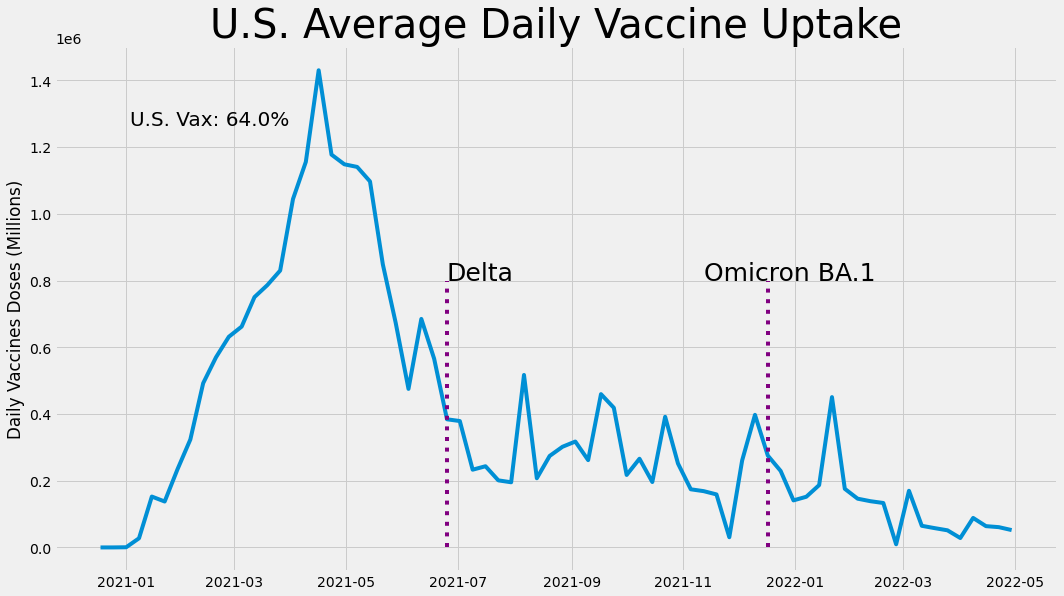

In [42]:
fontsize = 20


if True:
    base_name = "us_new_vax_timeline"
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()

    df['vax_day'] = (((df['vax_ct'].diff().fillna(0)) / 7) ).astype(int)

    df['vax_day'] = df['vax_day'].replace(df['vax_day'].max(),df['vax_day'].mean())

    #display(df[['Date','vax_day','vax_pct']])
    plt.figure(figsize=(16, 9))
    plt.plot(df['Date'],df['vax_day'])
    plt.title(f"U.S. Average Daily Vaccine Uptake",fontsize=fontsize*2)
    plt.ylabel('Daily Vaccines Doses (Millions)')
    
    x_col = "Date"
    y_col = "vax_day"
    vax_pct = "vax_pct"
    for i in range(2,(len(df[y_col]))):
        filename=f"{base_name}_{df['Date'].iloc[i].date()}_{str(i).zfill(3)}.png"
        filename=f"{base_name}_{str(i).zfill(3)}.png"
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.title(f"U.S. Average Daily Vaccine Uptake",fontsize=fontsize*2)
        plt.ylabel('Daily Vaccines Doses (Millions)')
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=800000,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)
            
        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=800000,offset=6,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        
        plt.savefig(project_dir.joinpath(filename))
        plt.show()

        plt.close()



In [ ]:
if True:

    base_name = "us_new_cases_timeline"
    y_col = 'New_Confirm_100k'
    ylabel_text = "(per 100k)"
    title = "U.S. Daily Cases (per 100k)"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        #filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{df['Date'].iloc[i].date()}_{str(i).zfill(3)}.png".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)

        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['c'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[:i].max():
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[:i].max():
            plot_add_date_markers(df,date='2021-12-24',ymax=500,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()




Rendering: us_new_hosp_timeline_072.png
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


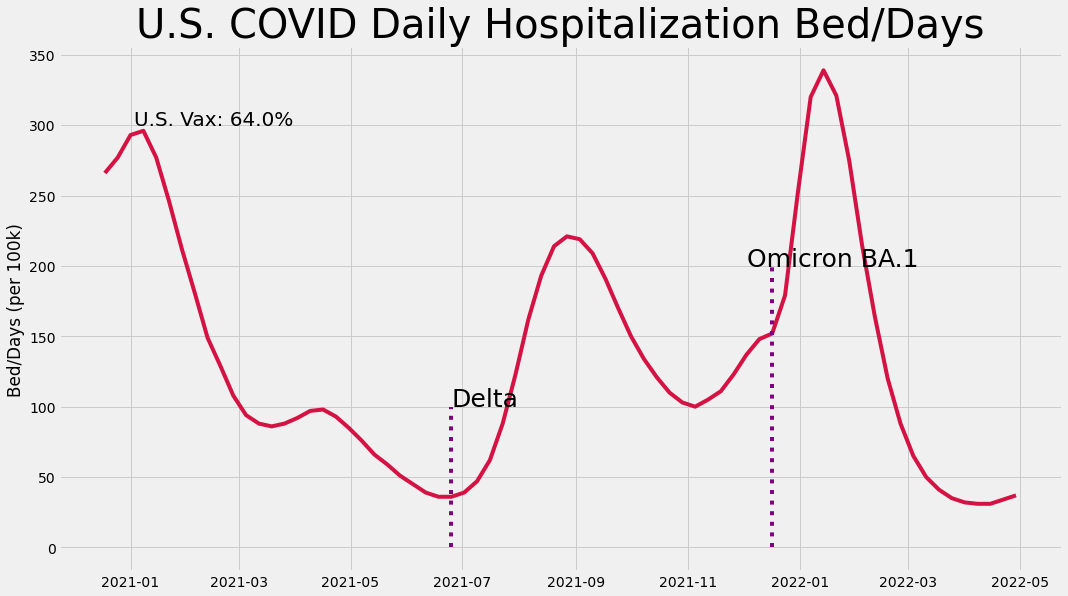

In [44]:
if True:

    base_name = "us_new_hosp_timeline"
    y_col = 'beds_covid_100k'
    ylabel_text = "Bed/Days (per 100k)"
    title = "U.S. COVID Daily Hospitalization Bed/Days"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['h'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=200,offset=3,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()




Rendering: us_new_icu_timeline_072.png
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


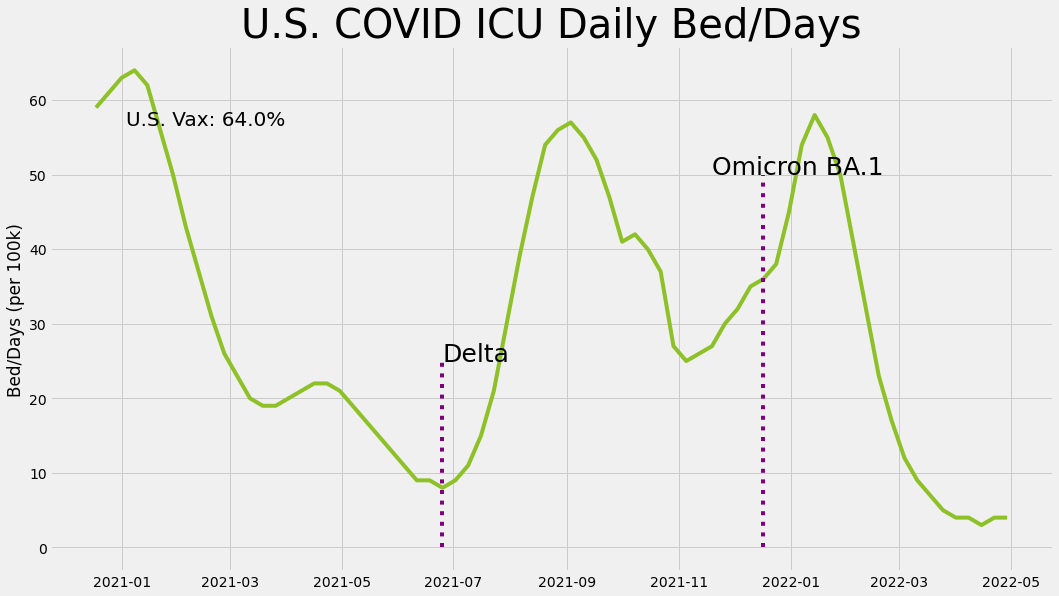

In [45]:

if True:

    base_name = "us_new_icu_timeline"
    y_col = 'icu_covid_100k'
    ylabel_text = "Bed/Days (per 100k)"
    title = "U.S. COVID ICU Daily Bed/Days"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['i'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=25,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=50,offset=5,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()
        



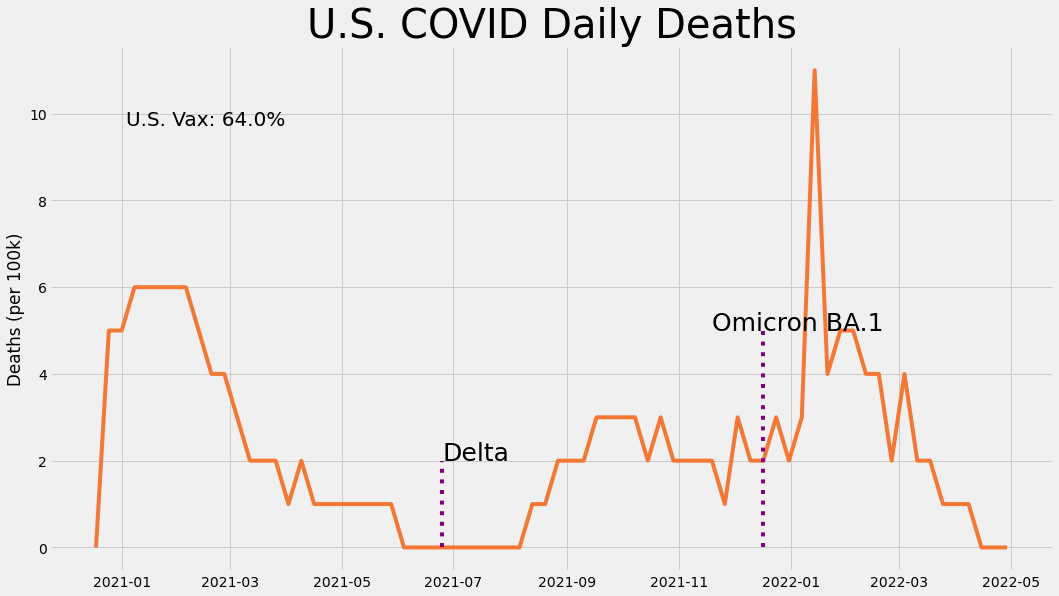

In [46]:

if True:

    base_name = "us_new_death_timeline"
    y_col = 'New_Deaths_100k'
    ylabel_text = "Deaths (per 100k)"
    title = "U.S. COVID Daily Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['d'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=2,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=5,offset=5,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        clear_output(wait=True)
        plt.savefig(project_dir.joinpath(filename))
        plt.show()




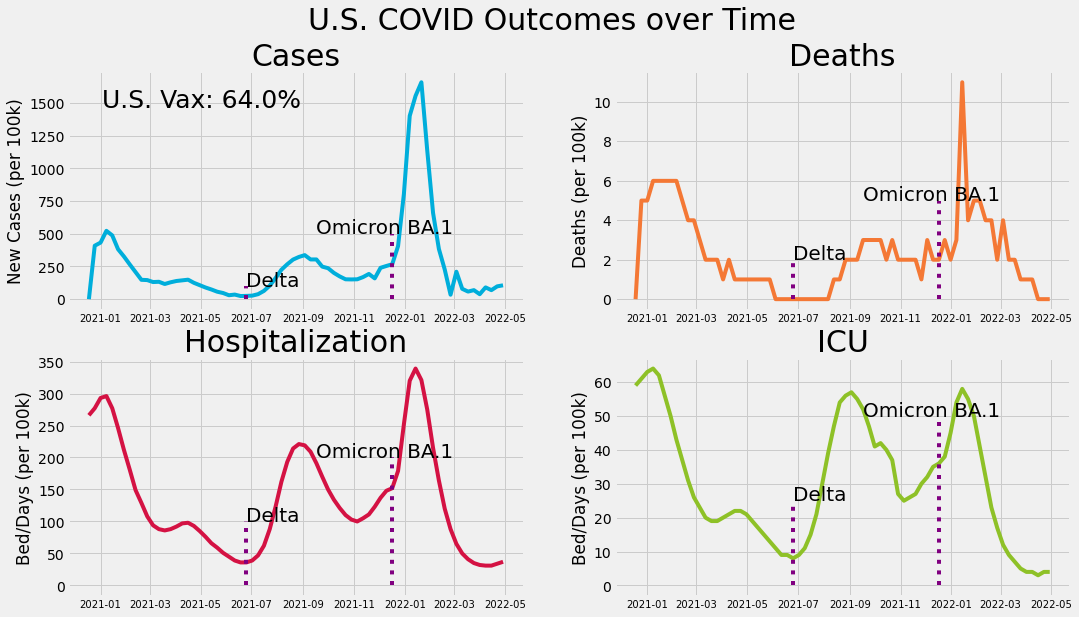

In [47]:
from PIL import Image

if True:
    base_name = "us_new_quad_timeline"
        

    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    gif_files = []
    first = True
    xtick_fontsize = fontsize*.5
    marker_fontsize= fontsize * 1
    for i in range(2,(len(df))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)

        print("Rendering:",filename)
        plt.figure(figsize=(16, 9))
        plt.suptitle("U.S. COVID Outcomes over Time",fontsize=fontsize*1.5)
        
        plt.subplot(2,2,1)
        y_col = 'New_Confirm_100k'
        ylabel_text = "New Cases (per 100k)"
        title = "Cases"
        
        
        plt.title(title,fontsize=fontsize*1.5)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['c'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize*1.25)
        plt.xticks(fontsize=xtick_fontsize)
        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=marker_fontsize)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=500,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=marker_fontsize)



        plt.subplot(2,2,2)
        y_col = 'New_Deaths_100k'
        ylabel_text = "Deaths (per 100k)"
        title = "Deaths"
        
        
        plt.title(title,fontsize=fontsize*1.5)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['d'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)
        plt.xticks(fontsize=xtick_fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=2,offset=1,text="Delta",col=vax_pct,fontsize=marker_fontsize)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=5,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=marker_fontsize)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.subplot(2,2,3)
        y_col = 'beds_covid_100k'
        ylabel_text = "Bed/Days (per 100k)"
        title = "Hospitalization"
        
        
        plt.title(title,fontsize=fontsize*1.5)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['h'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)
        plt.xticks(fontsize=xtick_fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=marker_fontsize)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=200,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=marker_fontsize)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        plt.subplot(2,2,4)
        y_col = 'icu_covid_100k'
        ylabel_text = "Bed/Days (per 100k)"
        title = "ICU"
        plt.xticks(fontsize=xtick_fontsize)
       
        
        plt.title(title,fontsize=fontsize*1.5)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['i'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=25,offset=1,text="Delta",col=vax_pct,fontsize=marker_fontsize)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=50,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=marker_fontsize)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        
        
        plt.savefig(project_dir.joinpath(filename))
        
        #//*** Read Files and Prepare Animated GID
        #if first == True:
        #    first=False
        #    first_img = Image.open(project_dir.joinpath(filename))
        #else:
        #    gif_files.append(Image.open(project_dir.joinpath(filename)) )
        
        clear_output(wait=True)
        plt.show()
        plt.close()
        

    #print("Building GIF...")

    #//*** Build and Save Animated GIF
    #gif_filename = f"{base_name}.gif"
    #first_img.save(gif_filename, save_all=True, optimize=False, append_images=gif_files, duration=150, loop=1)
    #del first
    #del gif files


# Matplotlib Color Maps #
https://matplotlib.org/stable/tutorials/colors/colormapnorms.html

In [48]:
cd.get('us_cdvh_df').columns

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

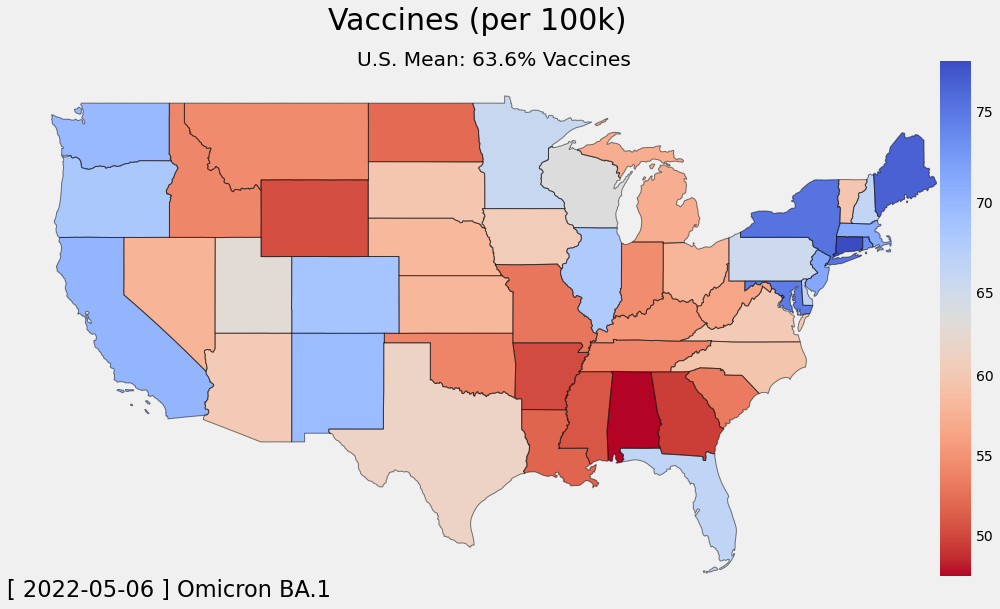

In [49]:
if True:
    reload(process_covid)
    base_name = "state_geo_vax_timeline"
    
    column ='vax_pct'
    title = "Vaccines (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)

        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)*100
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]
        geo_df= master_geo_df[master_geo_df['Date'] == master_geo_df['Date'].iloc[i]]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=title,
            title=f"U.S. Mean: {str(center)[:4]}% Vaccines",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=True,
            std=3,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                
        



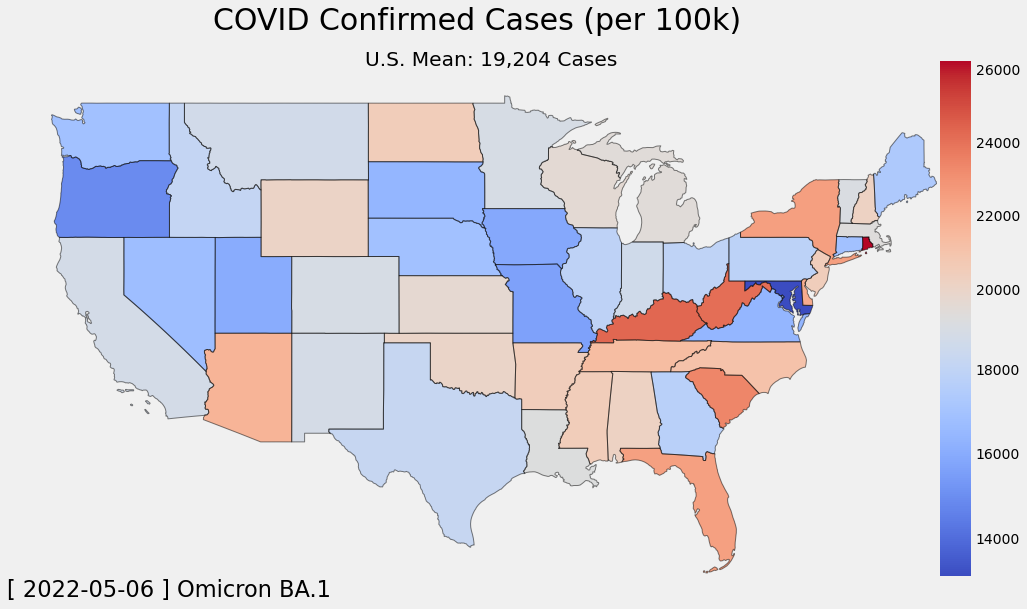

In [50]:

if True:
    reload(process_covid)
    base_name = "state_geo_confirm_timeline"
    
    column ='pv_New_Confirm_tot_100k'
    suptitle="COVID Confirmed Cases (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]
        geo_df= master_geo_df[master_geo_df['Date'] == master_geo_df['Date'].iloc[i]]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Cases ",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                
        



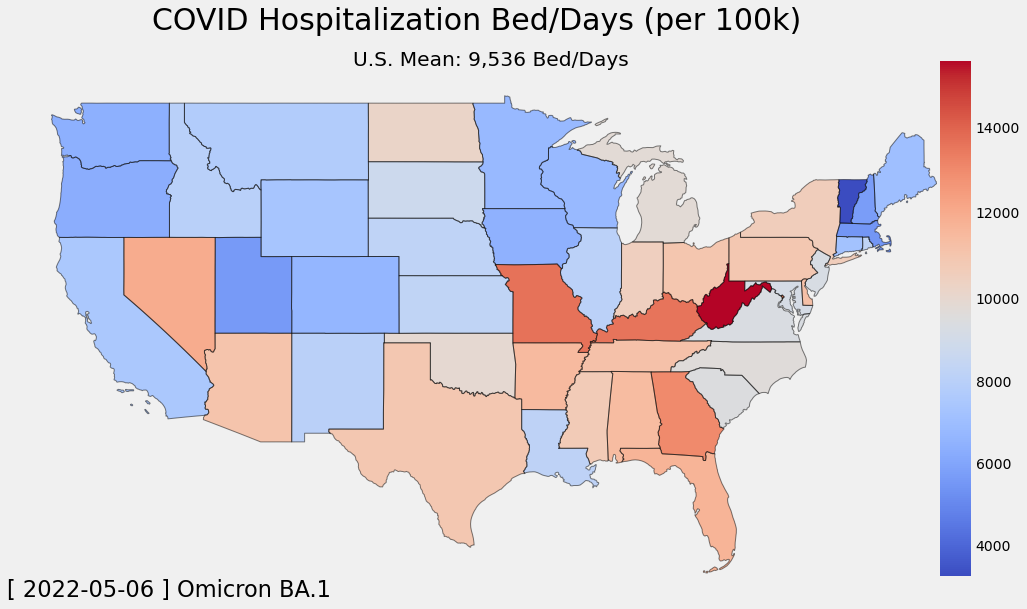

In [51]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_hosp_timeline"
    
    column ='pv_beds_covid_tot_100k'
    suptitle="COVID Hospitalization Bed/Days (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]
        geo_df= master_geo_df[master_geo_df['Date'] == master_geo_df['Date'].iloc[i]]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days ",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                

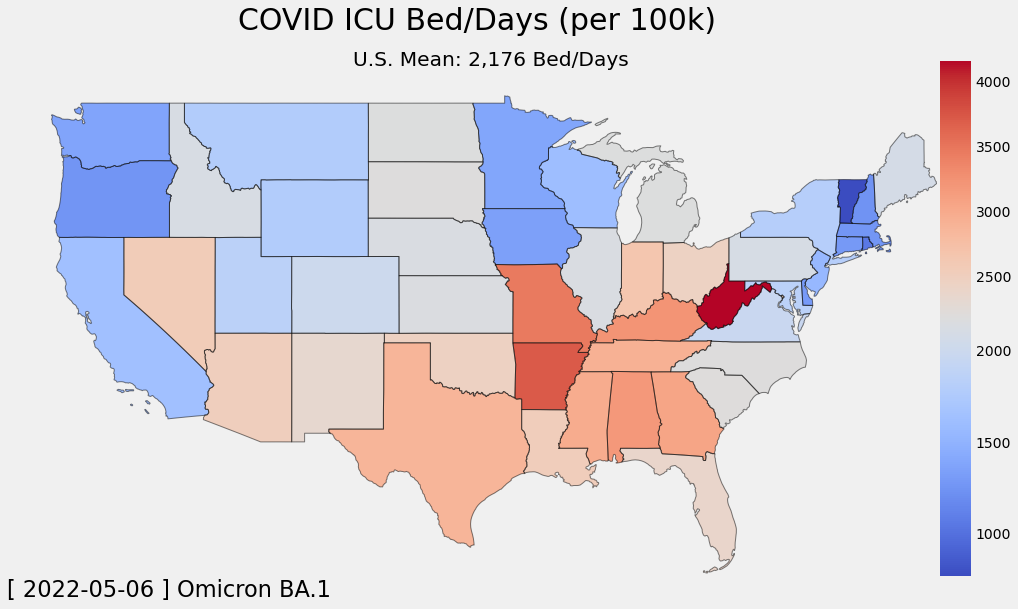

In [52]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_icu_timeline"
    
    column ='pv_icu_covid_tot_100k'
    suptitle="COVID ICU Bed/Days (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
       
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #go_df = master_geo_df[master_geo_df['Date'].isin(date_list)]
        geo_df= master_geo_df[master_geo_df['Date'] == master_geo_df['Date'].iloc[i]]
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days ",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                

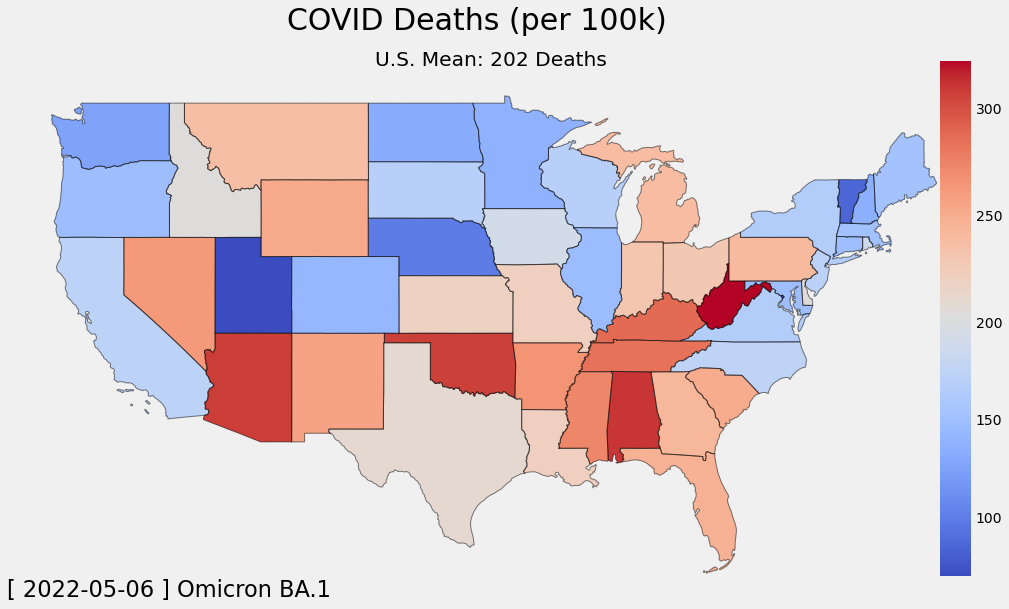

In [53]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_death_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    suptitle="COVID Deaths (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]
        geo_df= master_geo_df[master_geo_df['Date'] == master_geo_df['Date'].iloc[i]]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Deaths ",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               

-  [Build state_cvdh_df](#build-state_cvdh_df).

In [54]:
df = cd.get('state_cvdh_df').copy()
df['vax_pct'] = df['vax_pct'] * 100

df

Date    state        pop    vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18  Alabama  4789955.0       0.0     308218.0      4163.0   
1  2020-12-25  Alabama  4789955.0       0.0     334449.0      4537.0   
2  2021-01-01  Alabama  4789955.0       0.0     357264.0      4728.0   
3  2021-01-08  Alabama  4789955.0    1375.0     385200.0      5023.0   
4  2021-01-15  Alabama  4789955.0   12302.0     407961.0      5835.0   
..        ...      ...        ...       ...          ...         ...   
68 2022-04-08  Wyoming   568928.0  284325.0     154358.0      1769.0   
69 2022-04-15  Wyoming   568928.0  284784.0     154336.0      1774.0   
70 2022-04-22  Wyoming   568928.0  285539.0     154470.0      1780.0   
71 2022-04-29  Wyoming   568928.0  286022.0     154628.0      1785.0   
72 2022-05-06  Wyoming   568928.0  286423.0     154822.0      1787.0   

    beds_covid  icu_covid     beds  beds_used  all_icu  icu_used    vax_pct  \
0      17882.0     4668.0  98411.0    73083.0  15212.0   13069.0   0.000000   
1      19501.0     5183.0  98370.0    71605.0  15128.0   13005.0   0.000000   
2      21504.0     5712.0  97836.0    75318.0  15199.0   13516.0   0.000000   
3      21581.0     5953.0  98002.0    76925.0  15073.0   13578.0   0.028706   
4      19488.0     5717.0  97283.0    75924.0  14850.0   13301.0   0.256829   
..         ...        ...      ...        ...      ...       ...        ...   
68        28.0        1.0   9733.0     3786.0    835.0     251.0  49.975568   
69        48.0        0.0   9623.0     3671.0    824.0     257.0  50.056246   
70        42.0        0.0   9659.0     3926.0    827.0     267.0  50.188952   
71        58.0        4.0   9708.0     3826.0    837.0     280.0  50.273848   
72        35.0        3.0   9824.0     4030.0    844.0     283.0  50.344332   

    New_Confirm  New_Deaths  pv_New_Confirm_tot  pv_New_Deaths_tot  \
0           0.0         0.0                 0.0                0.0   
1       26231.0       374.0             26231.0              374.0   
2       22815.0       191.0             49046.0              565.0   
3       27936.0       295.0             76982.0              860.0   
4       22761.0       812.0             99743.0             1672.0   
..          ...         ...                 ...                ...   
68        115.0         5.0            113561.0             1423.0   
69        -22.0         5.0            113539.0             1428.0   
70        134.0         6.0            113673.0             1434.0   
71        158.0         5.0            113831.0             1439.0   
72        194.0         2.0            114025.0             1441.0   

    beds_covid_tot  icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  \
0          17882.0         4668.0   98411.0        73083.0      15212.0   
1          37383.0         9851.0  196781.0       144688.0      30340.0   
2          58887.0        15563.0  294617.0       220006.0      45539.0   
3          80468.0        21516.0  392619.0       296931.0      60612.0   
4          99956.0        27233.0  489902.0       372855.0      75462.0   
..             ...            ...       ...            ...          ...   
68         42627.0        10288.0  668971.0       279708.0      60469.0   
69         42675.0        10288.0  678594.0       283379.0      61293.0   
70         42717.0        10288.0  688253.0       287305.0      62120.0   
71         42775.0        10292.0  697961.0       291131.0      62957.0   
72         42810.0        10295.0  707785.0       295161.0      63801.0   

    icu_used_tot  pv_beds_covid_tot  pv_icu_covid_tot  pv_beds_tot  \
0        13069.0                0.0               0.0          0.0   
1        26074.0            19501.0            5183.0      98370.0   
2        39590.0            41005.0           10895.0     196206.0   
3        53168.0            62586.0           16848.0     294208.0   
4        66469.0            82074.0           22565.0     391491.0   
..           ...                .

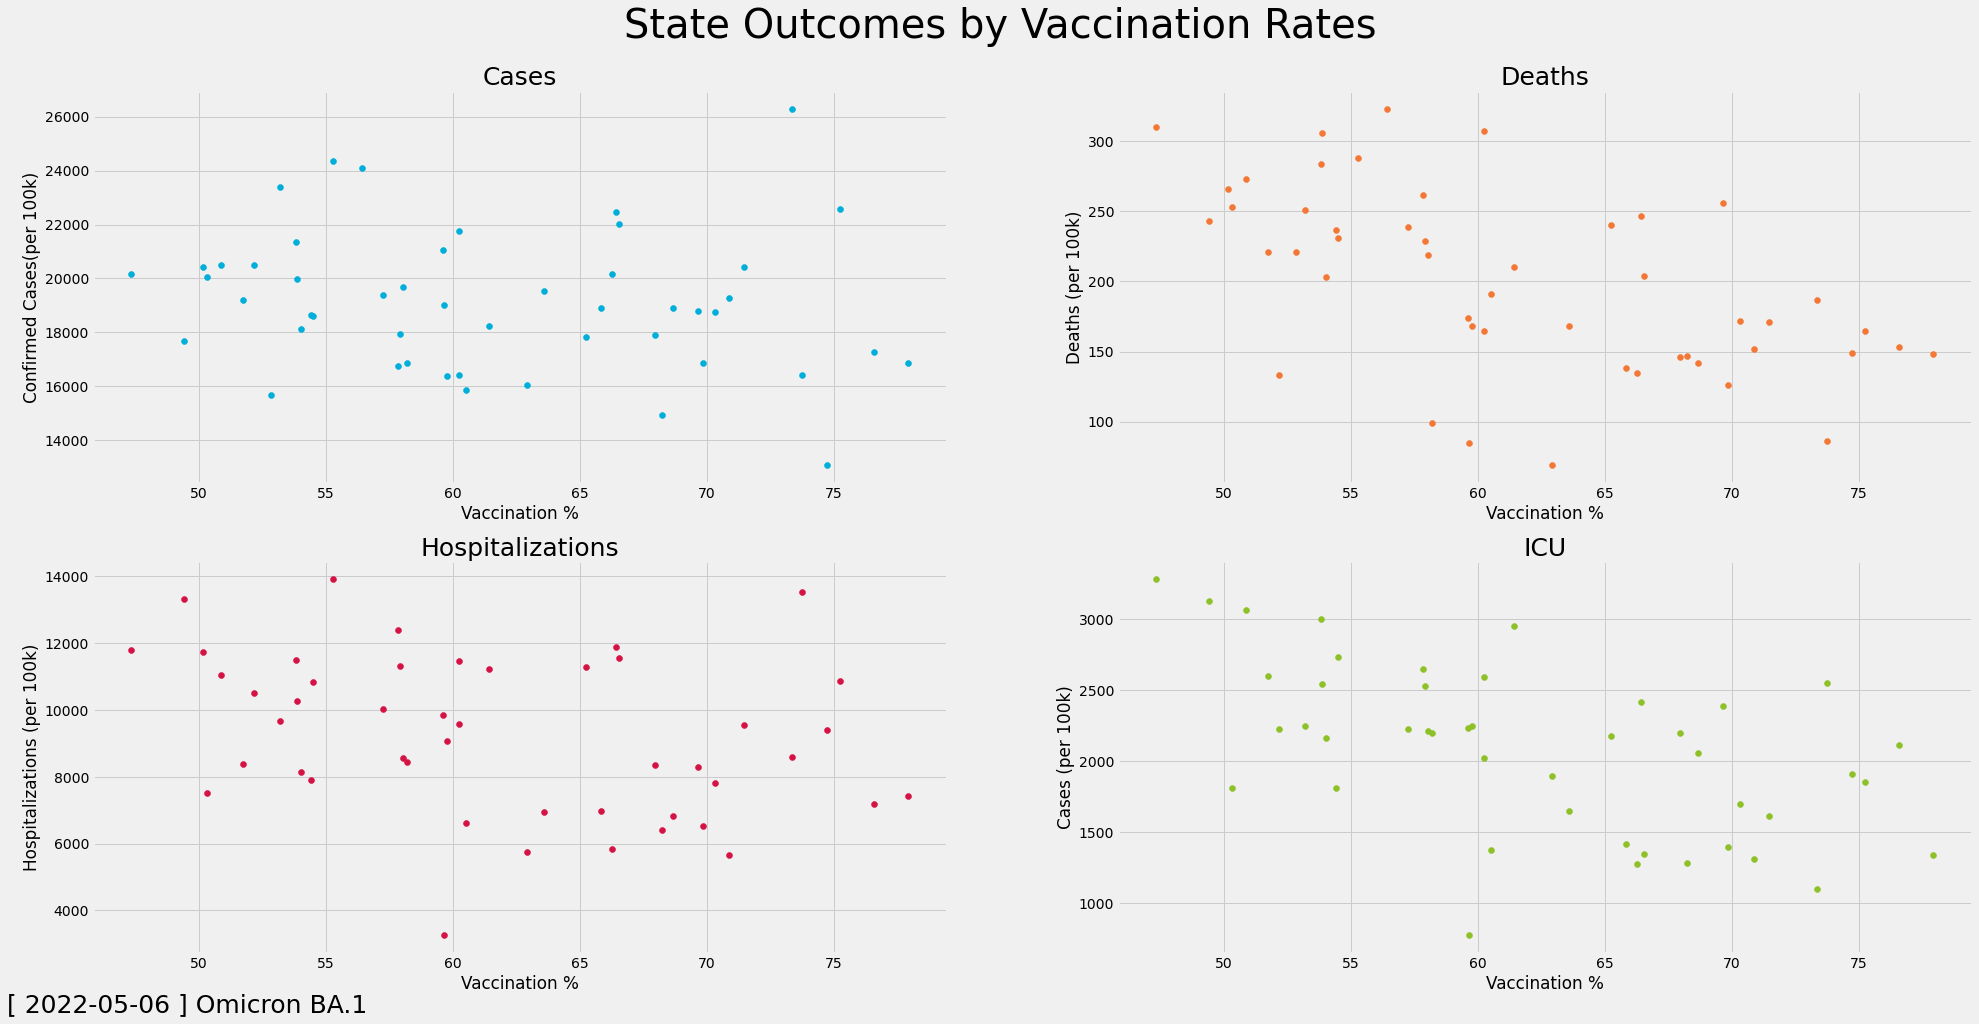

In [55]:
fontsize=20
if True:
    reload(process_covid)
    base_name = "state_date_vax_quad_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    
    #plt.xticks(fontsize=xtick_fontsize)
       
        
        
    title_fontsize = fontsize*1.25
    
    for i in range(2,len(df['Date'].unique())):
        
        #df = cd.get('week_cdvh_df').copy()
        df = cd.get('state_cvdh_df').copy()
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        
        plt.figure(figsize=(30, 9))

        plt.suptitle("State Outcomes by Vaccination Rates",fontsize=fontsize*2,y=1.53)

        plt.subplot(2, 2, 1)#//*** Left Boxx


        column = 'pv_New_Confirm_tot_100k'


        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.title("Cases",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Confirmed Cases(per 100k)")


    
        




        column = 'pv_New_Deaths_tot_100k'
        df.loc[(df[column] < 0), column] = 0

        plt.subplot(2, 2, 2)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.title("Deaths",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Deaths (per 100k)")


        column = 'beds_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]


        plt.subplot(2, 2, 3)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.title("Hospitalizations",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Hospitalizations (per 100k)")

        column = 'icu_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        plt.subplot(2, 2, 4)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.title("ICU",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Cases (per 100k)")
        
        coords=(-1.3,-.15)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        
        #fig.tight_layout()
        plt.subplots_adjust(top=1.4)
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

        clear_output(wait=True)
        plt.show()
        

Rendered county_geo_vax_timeline_072.png


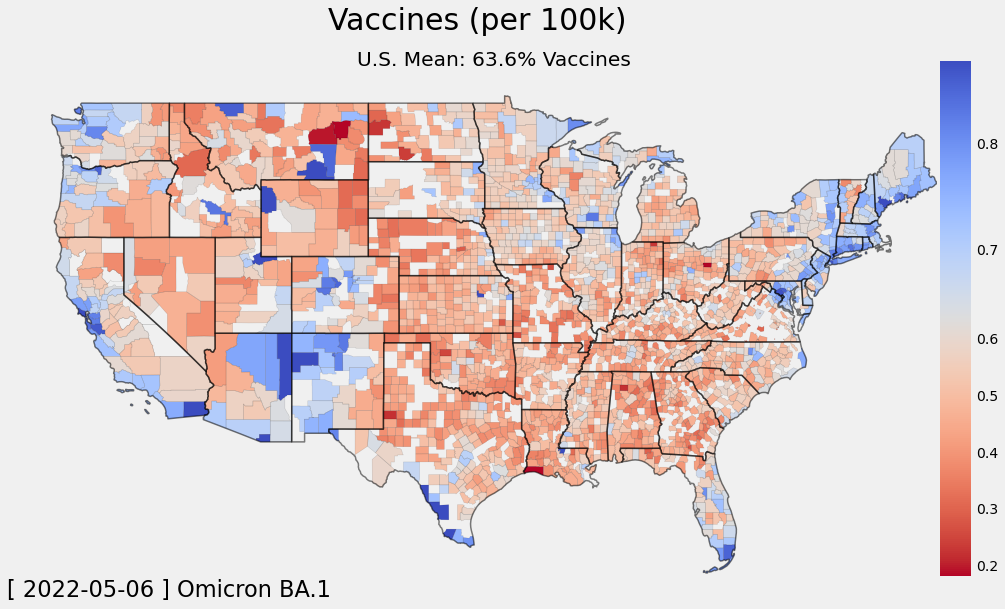

In [56]:
if True:
    reload(process_covid)
    base_name = "county_geo_vax_timeline"
    
    column ='vax_pct'
    suptitle = "Vaccines (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        
        #reload(process_covid)
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)

        

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        geo_df.loc[(geo_df[column] < 0), column] = 0
        
        geo_df['vax_pct'] = (geo_df['vax_ct'] / geo_df['pop'])
        #print(column,center,df[column].mean(),len(geo_df))
        #print(geo_df[column].describe())
        #display(geo_df[['Date','GEOID','pop','vax_ct','vax_pct']])
        
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {str(center*100)[:4]}% Vaccines",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=True,
            std=3,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
      
        
          
        



Rendered county_geo_confirm_timeline_072.png


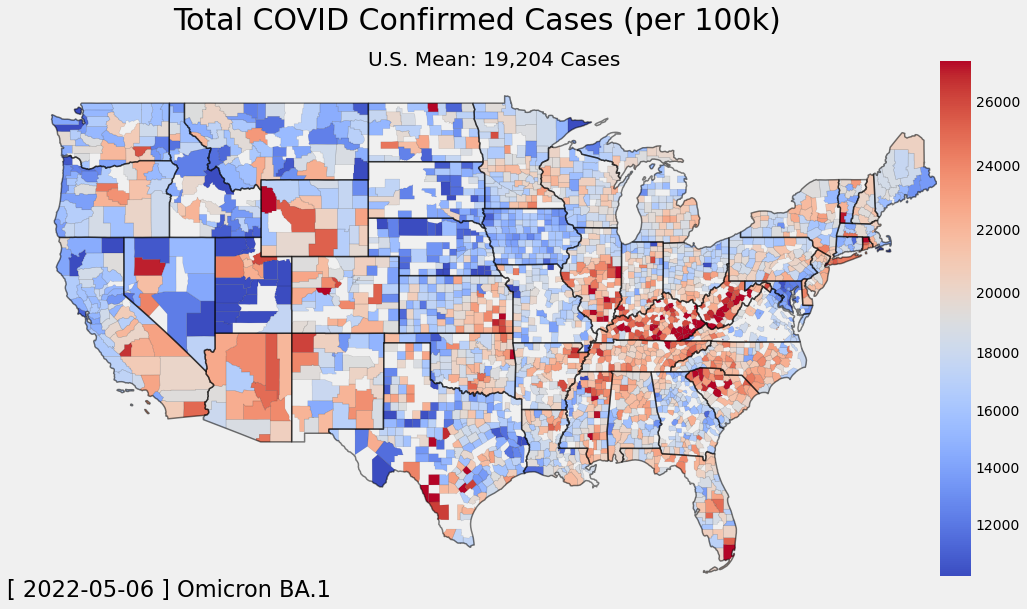

In [57]:
if True:
    reload(process_covid)
    base_name = "county_geo_confirm_timeline"
    
    column ='pv_New_Confirm_tot_100k'
    suptitle = "Total COVID Confirmed Cases (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        
        #reload(process_covid)
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        
        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Cases",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
      
        



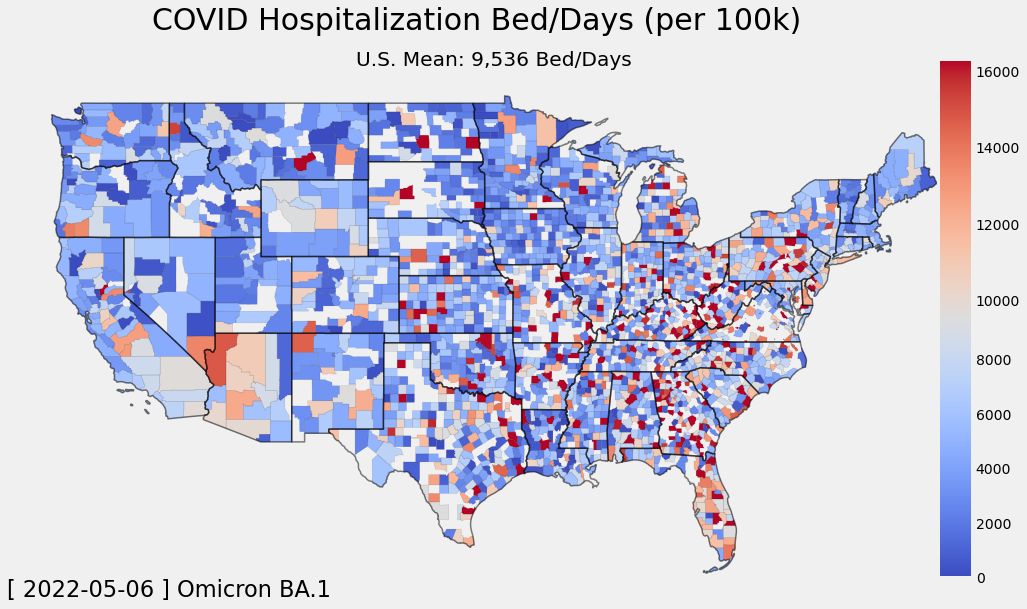

In [58]:
if True:
    reload(process_covid)
    base_name = "county_geo_hosp_timeline"
    
    column ='pv_beds_covid_tot_100k'
    suptitle = "COVID Hospitalization Bed/Days (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        #date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        
        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=1,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               
        





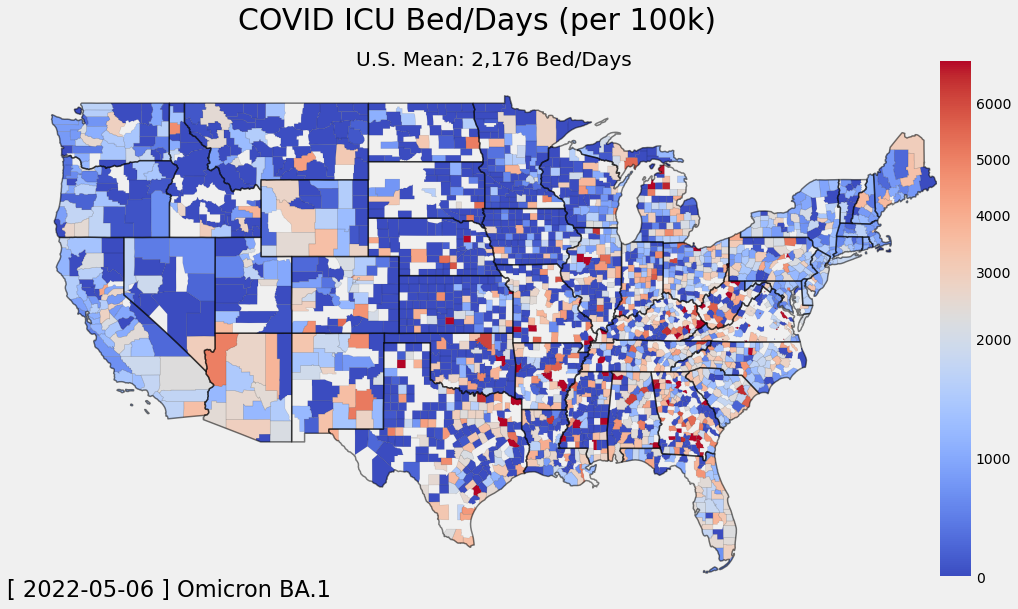

In [59]:

    
if True:
    reload(process_covid)
    base_name = "county_geo_icu_timeline"
    
    column ='pv_icu_covid_tot_100k'
    suptitle = "COVID ICU Bed/Days (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()

        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               
        





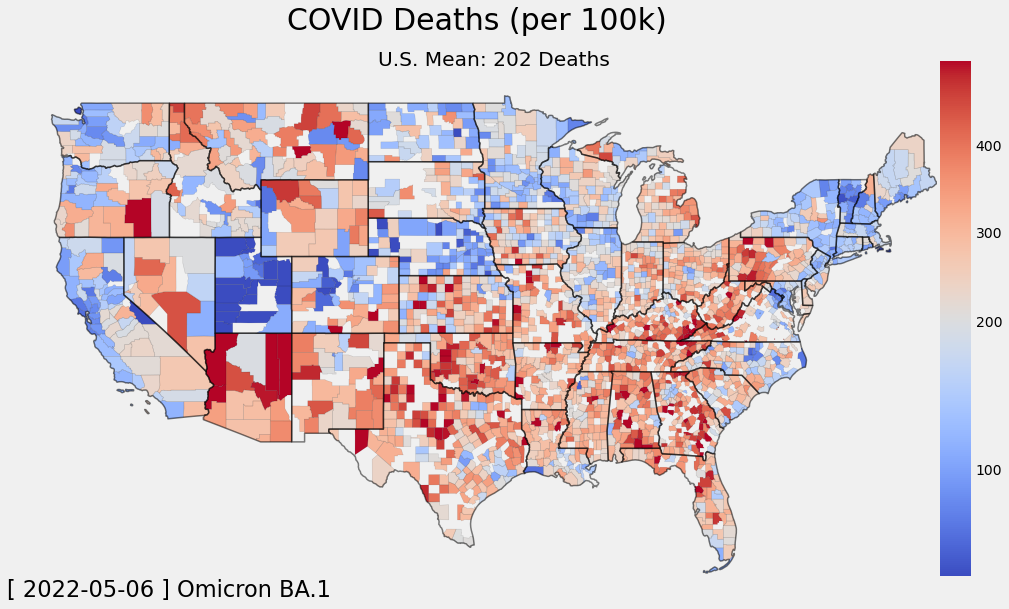

In [60]:
   
if True:
    reload(process_covid)
    base_name = "county_geo_death_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    suptitle = "COVID Deaths (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()

        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Deaths",
            cmap='coolwarm',
            figsize=(16,9),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                   


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

count      2423.000000
mean       7184.086669
std        9130.788228
min           0.000000
25%        2912.000000
50%        5388.000000
75%        9437.000000
max      315688.000000
Name: pv_beds_covid_tot_100k, dtype: float64

<AxesSubplot:>

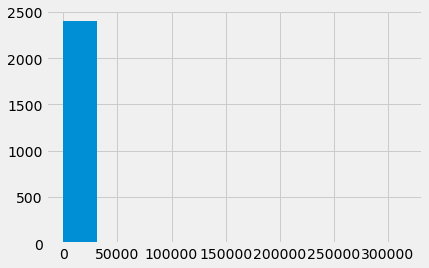

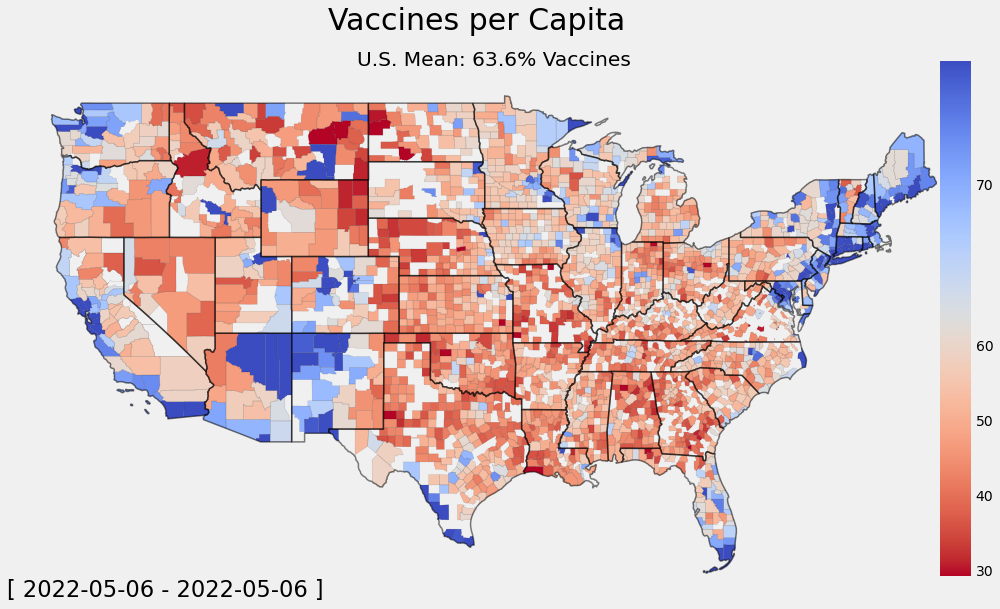

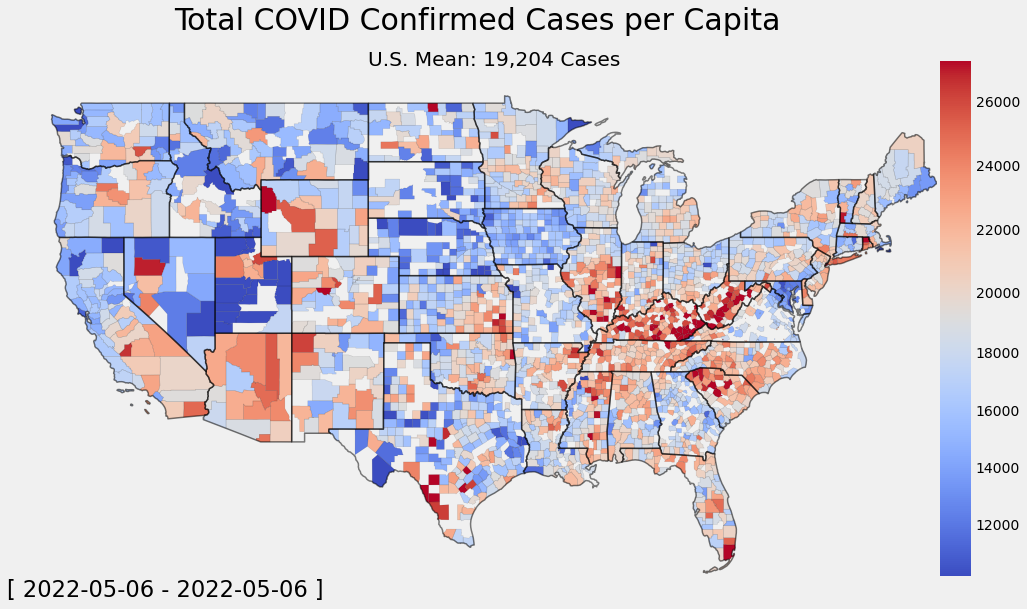

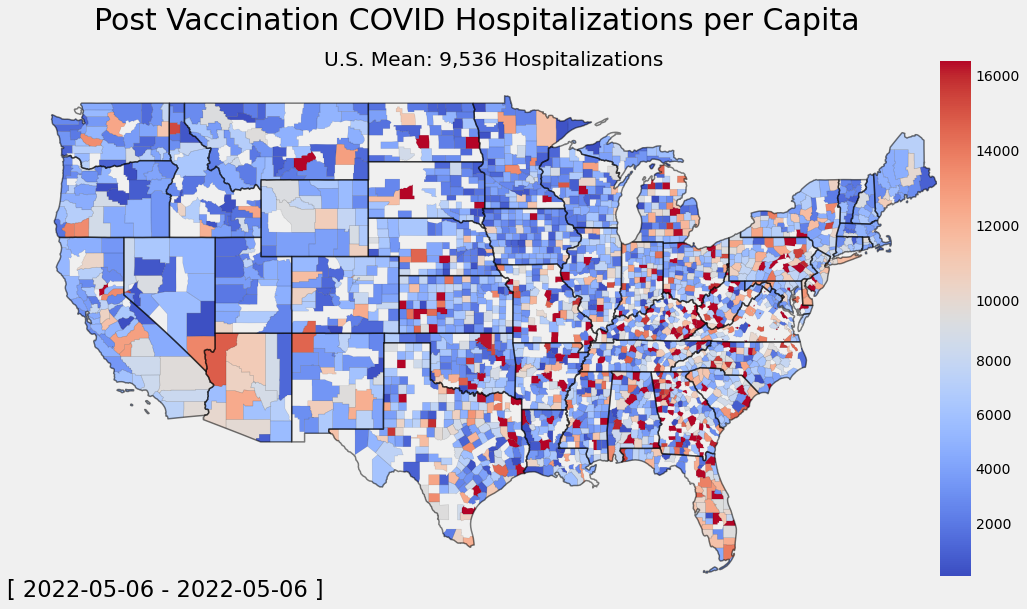

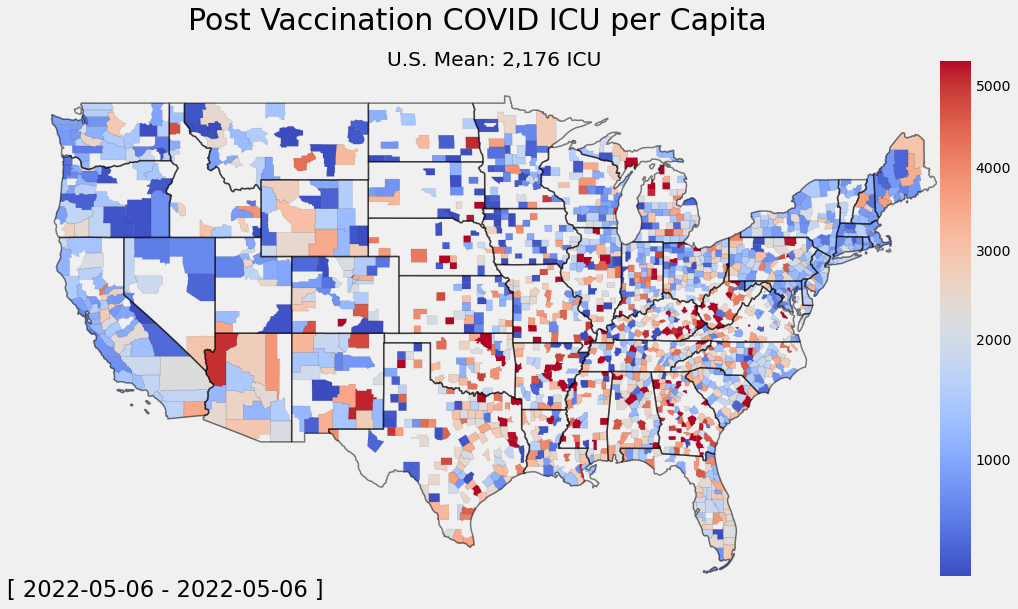

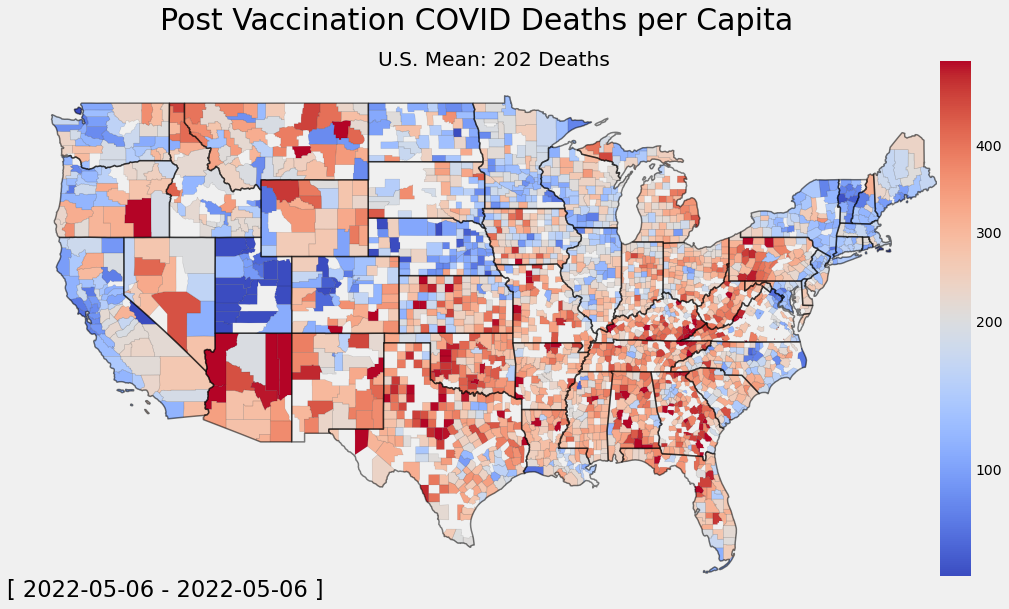

In [61]:
#cd.l()
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]


display(df.columns)
cmap = cm.coolwarm
geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
display(df['pv_beds_covid_tot_100k'].describe())
display(df['pv_beds_covid_tot_100k'].hist())
column = 'vax_pct'
center = round(cd.get('us_cdvh_df')[column].iloc[-1],3)*100
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines per Capita",
    title=f"U.S. Mean: {center:,}% Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(16,9),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Total COVID Confirmed Cases per Capita",
    title=f"U.S. Mean: {center:,} Cases",
    figsize=(16,9),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'pv_beds_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Hospitalizations per Capita",
    title=f"U.S. Mean: {center:,} Hospitalizations",
    figsize=(16,9),
    state_geo = cd.get('state_geo_df'),
    std=1
    #vmax=13908,
    
    )


column = 'pv_icu_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID ICU per Capita",
    title=f"U.S. Mean: {center:,} ICU",
    figsize=(16,9),
    state_geo = cd.get('state_geo_df'),
    std=1
     #vmax=us_total_icu_mean*2,
    #vmin=int(us_total_icu_mean/2)

    )


column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Deaths per Capita",
    title=f"U.S. Mean: {center:,} Deaths",
    figsize=(16,9),
    state_geo = cd.get('state_geo_df'),
    #vmin=100,
    #vmax=1000,
     
    )







In [62]:
"""
df_bv = cd.get('week_cdvh_df').copy()
df_bv = df_bv[df_bv["Date"]== df_bv["Date"].min()]

#display(df_bv.columns)
bv_geo_df = cd.get("county_geo_df").copy().merge(df_bv,left_on="GEOID",right_on="FIPS")

#display(df.columns)

column = 'tot_confirm_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Before Vaccines: Total COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'vax_ct_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines (per 100k)",
    title=f"U.S. Mean: {center} Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )


column = 'tot_deaths_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Pre-Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

"""
print()


In [63]:
cd.l()

Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


Rendered date_vax_new_cases_timeline_1_072.png


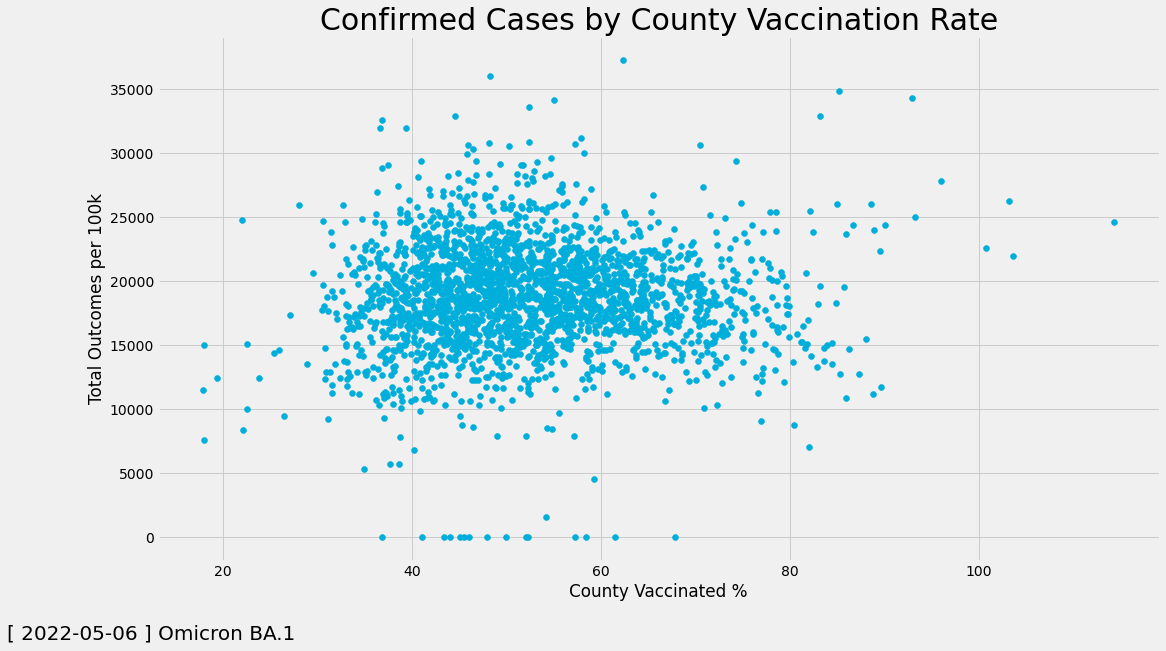

In [64]:
if True:
    reload(process_covid)
    base_name = "date_vax_new_cases_timeline_1"
    
    column ='pv_New_Confirm_tot_100k'
    title = "Confirmed Cases by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    

    us_df = cd.get('us_cdvh_df')
    
    
    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        df = df[df[column] < df[column].max()]
        
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Total Outcomes per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)

        #plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        #print("Mean:",)
        #us_mean = us_df[us_df['Date'] == df['Date'].max()][column].values[0]
        #//*** Draw Mean
        #plt.hlines(us_mean,xmin=0,xmax=df['vax_pct'].max(),color=color_dict['mean'])

        #//*** Add mean legend
        #mean_patch = mpatches.Patch(color=color_dict['mean'], label=f'U.S. Mean: < {us_mean:,}')
        #plt.legend(handles=[mean_patch])

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        
        
        



Rendered date_vax_new_cases_timeline_2_072.png


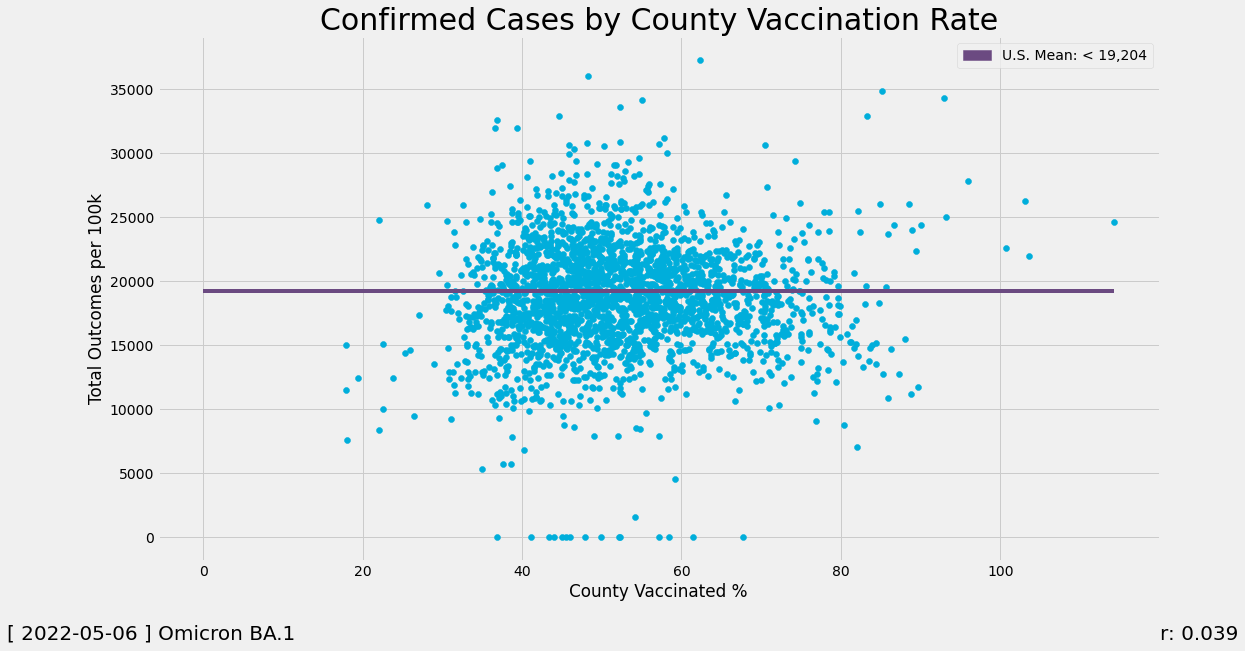

In [65]:
color_dict['mean'] = "#ae92c1"
color_dict['mean'] = "#6b4a81"




if True:
    reload(process_covid)
    base_name = "date_vax_new_cases_timeline_2"
    
    column ='pv_New_Confirm_tot_100k'
    title = "Confirmed Cases by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    

    us_df = cd.get('us_cdvh_df')
    
    
    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        df = df[df[column] < df[column].max()]
        
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Total Outcomes per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)

        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        #print("Mean:",)
        us_mean = us_df[us_df['Date'] == df['Date'].max()][column].values[0]
        #//*** Draw Mean
        plt.hlines(us_mean,xmin=0,xmax=df['vax_pct'].max(),color=color_dict['mean'])

        #//*** Add mean legend
        mean_patch = mpatches.Patch(color=color_dict['mean'], label=f'U.S. Mean: < {us_mean:,}')
        plt.legend(handles=[mean_patch])

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        
        
        



Rendered date_vax_deaths_timeline_072.png


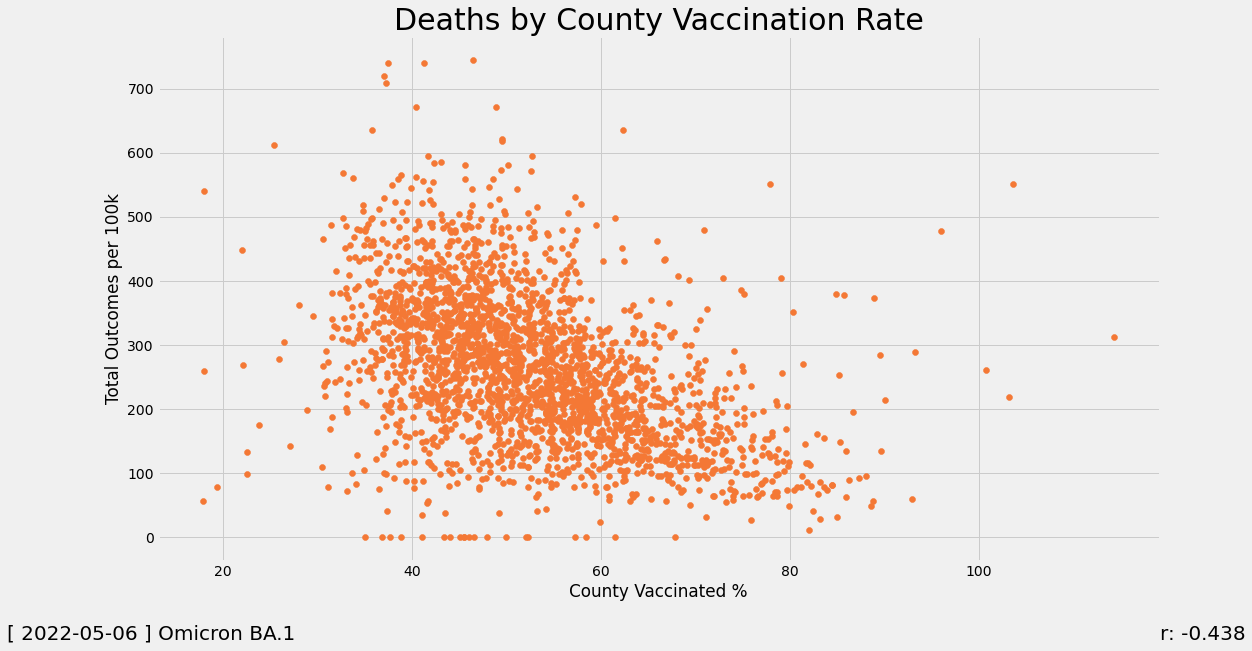

In [66]:
if True:
    reload(process_covid)
    base_name = "date_vax_deaths_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    title = "Deaths by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        df = df[df[column] < df[column].max()]
        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Total Outcomes per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



Rendered date_vax_hosp_timeline_072.png


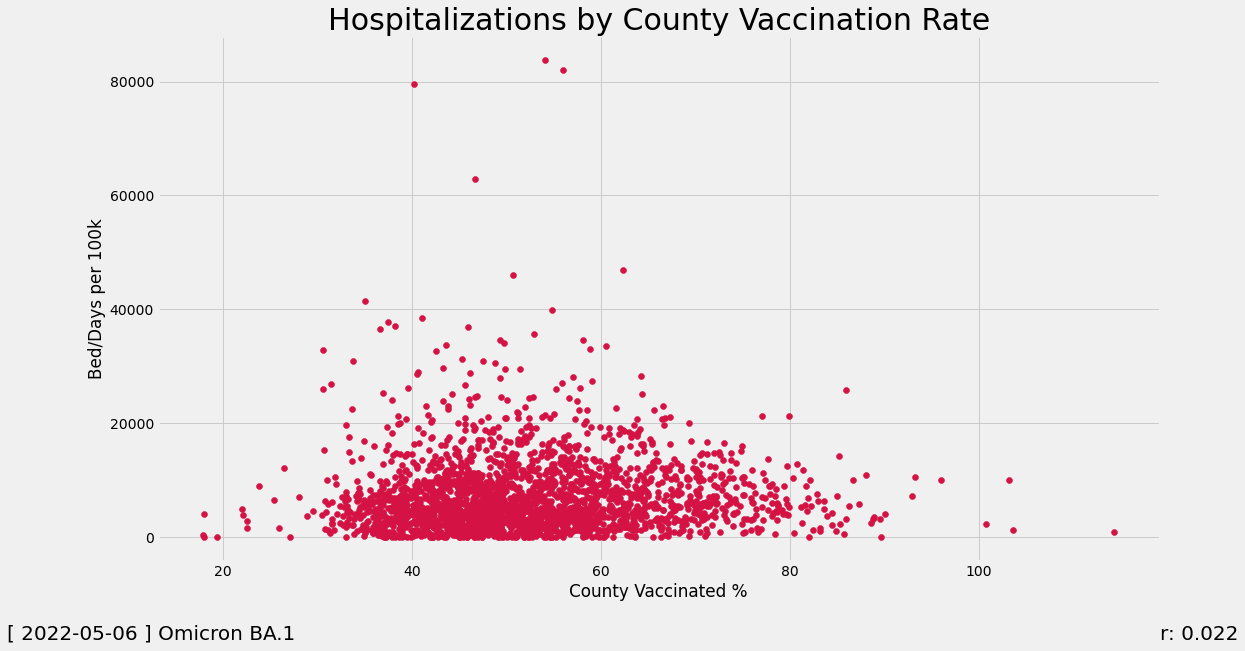

In [67]:
if True:
    reload(process_covid)
    base_name = "date_vax_hosp_timeline"
    
    column ='beds_covid_tot_100k'
    title = "Hospitalizations by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Bed/Days per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



Rendered date_vax_icu_timeline_072.png


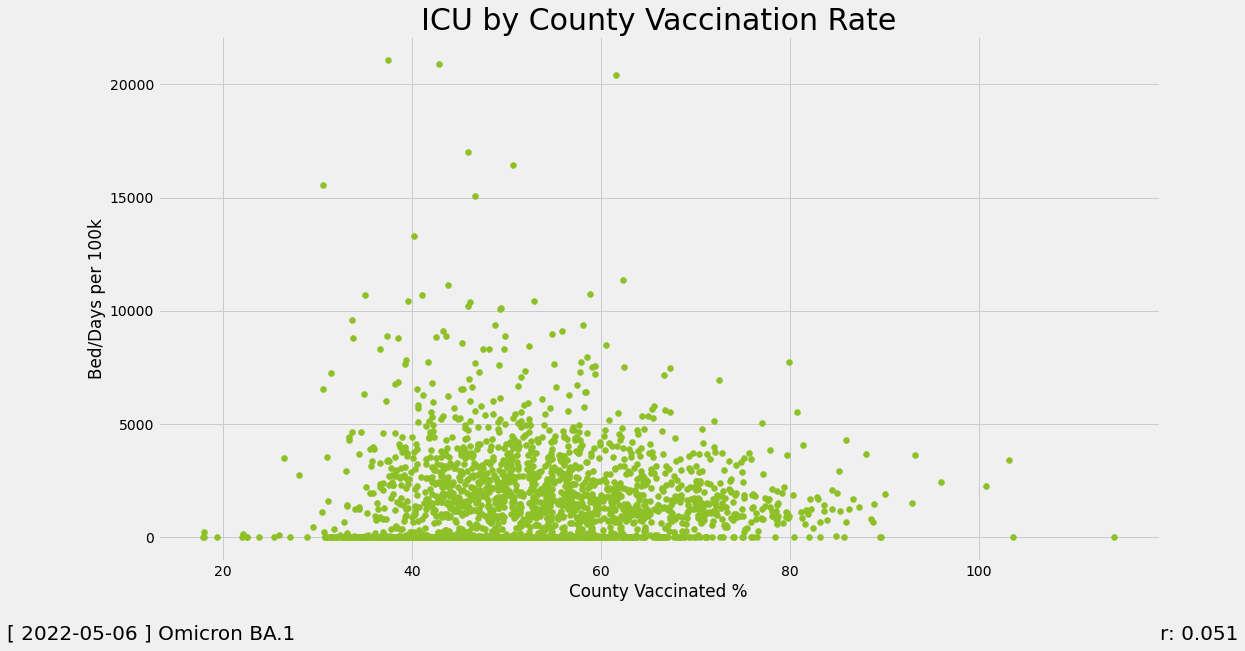

In [68]:
if True:
    reload(process_covid)
    base_name = "date_vax_icu_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(16, 9))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Bed/Days per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



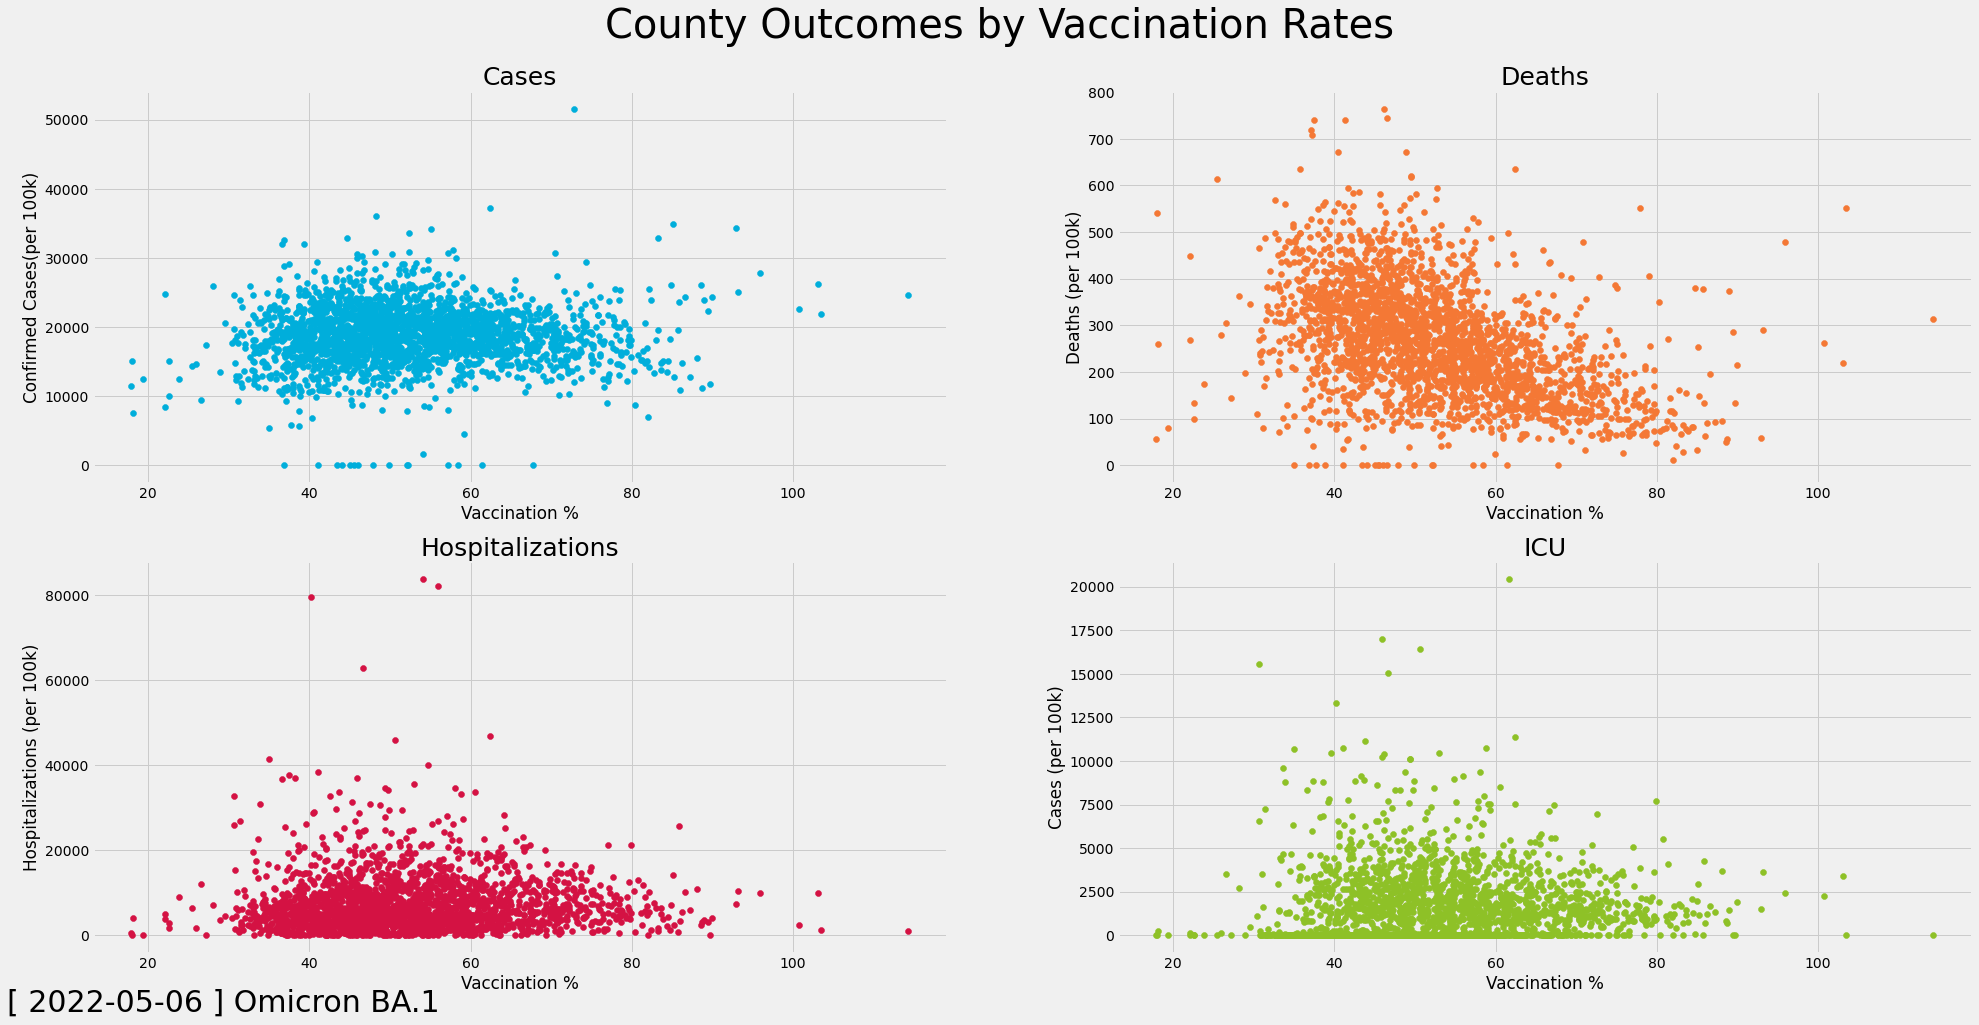

In [69]:
if True:
    reload(process_covid)
    base_name = "date_vax_quad_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    title_fontsize = fontsize*1.25

    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        
        plt.figure(figsize=(30, 9))
        plt.suptitle("County Outcomes by Vaccination Rates",fontsize=fontsize*2,y=1.53)

        plt.subplot(2, 2, 1)#//*** Left Boxx


        column = 'pv_New_Confirm_tot_100k'


        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.title("Cases",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Confirmed Cases(per 100k)")


        




        column = 'pv_New_Deaths_tot_100k'
        df.loc[(df[column] < 0), column] = 0

        plt.subplot(2, 2, 2)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.title("Deaths",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Deaths (per 100k)")


        column = 'beds_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]


        plt.subplot(2, 2, 3)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.title("Hospitalizations",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Hospitalizations (per 100k)")

        column = 'icu_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        plt.subplot(2, 2, 4)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.title("ICU",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Cases (per 100k)")
        
        coords=(-1.3,-.15)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.subplots_adjust(top=1.4)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

        clear_output(wait=True)
        plt.show()


# Working #

<a id="working"></a> 

[Top](#top)

# People Get vaccinated because of outcomes. In the highest vax Counties. That doesn't hold if Vax Rate is constant #

# Build IQR Vax Collection #

In [70]:

reload(process_covid)
vax_collection_IQR = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
#gp = df.boxplot(column='vax_pct')
#gp.plot()
#display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}

#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    

    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    loop_df['count'] = len(vax_cty)
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_IQR.add(loop_df,'low',f"IQR Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_IQR.add(loop_df,'med',f"IQR Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_IQR.add(loop_df,'high',f"IQR High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_IQR.l()


count    2414.000000
mean       52.540348
std        11.710452
min        17.900000
25%        44.000000
50%        51.200000
75%        59.400000
max        95.000000
Name: vax_pct, dtype: float64

Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

601
Counties: 601 Rows: 43851 POP:  18 Million
1208
Counties: 1208 Rows: 87994 POP:  99 Million
605
Counties: 605 Rows: 44158 POP:  195 Million
Collected Dataframe Count:  3
[low] Desc: IQR Low Vaccine Counties  (44.0% <) 
[med] Desc: IQR Medium Vaccine Counties, (44.0% - 59.4%)
[high] Desc: IQR High Vaccine Counties, (59.4%) >


In [71]:
"""
reload(process_covid)
vax_collection_STD = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
display(df['vax_pct'].mean() - df['vax_pct'].std(),df['vax_pct'].mean(),df['vax_pct'].mean() + df['vax_pct'].std())
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

#//*** Mean minus std Dev
q1 = df['vax_pct'].mean() - df['vax_pct'].std()

#//*** Mean plus std Dev
q3 = df['vax_pct'].mean() + df['vax_pct'].std()

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
gp = df.boxplot(column='vax_pct')
gp.plot()
display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}
#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['count'] = len(vax_cty)
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_STD.add(loop_df,'low',f"STD Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_STD.add(loop_df,'med',f"STD Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_STD.add(loop_df,'high',f"STD High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_STD.l()

"""
pass

In [72]:
if True:
    base_name = "distrib_vax"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass


    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]
    iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
    iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

    
    plt.figure(figsize=figsize)
    df['vax_pct'].hist(figsize=[12, 8], bins=40)
   
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=200,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=200,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0001_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()
    
    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0002_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0003_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0004_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0005_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0006_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0007_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0009_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)
    

    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()    

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0010_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show() 
    
    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0011_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('high')
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.7,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show() 

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0012_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('high').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.7,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    county_count = vax_collection_IQR.get('low').copy()
    
    plt.annotate(f"{county_count['count'].unique()[0]} counties",(0.07,.45),xycoords='axes fraction',fontsize=fontsize*1)

    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()     

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0013_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('high').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.7,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    county_count = vax_collection_IQR.get('low').copy()
    
    plt.annotate(f"{county_count['count'].unique()[0]} counties",(0.07,.45),xycoords='axes fraction',fontsize=fontsize*1)

    county_count = vax_collection_IQR.get('med').copy()
    
    plt.annotate(f"{county_count['count'].unique()[0]:,} counties",(0.37,.45),xycoords='axes fraction',fontsize=fontsize*1)

    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()     

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=155,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.6),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0014_{base_name}_.jpg"
    
    pop = vax_collection_IQR.get('low').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('high').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.7,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    county_count = vax_collection_IQR.get('low').copy()
    plt.annotate(f"{county_count['count'].unique()[0]} counties",(0.07,.45),xycoords='axes fraction',fontsize=fontsize*1)

    county_count = vax_collection_IQR.get('med').copy()
    plt.annotate(f"{county_count['count'].unique()[0]:,} counties",(0.37,.45),xycoords='axes fraction',fontsize=fontsize*1)

    county_count = vax_collection_IQR.get('high').copy()
    plt.annotate(f"{county_count['count'].unique()[0]} counties",(0.72,.45),xycoords='axes fraction',fontsize=fontsize*1)

    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()     
        

NameError: name 'figsize' is not defined

In [ ]:
import matplotlib.patches as mpatches
if True:
    base_name = "tier_vax_counties"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass
    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    #vax_collection_iqr = 
    iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
    iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)
    #//*** Mean minus std Dev
    std_q1 = df['vax_pct'].mean() - df['vax_pct'].std()

    #//*** Mean plus std Dev
    std_q3 = df['vax_pct'].mean() + df['vax_pct'].std()

    #//*** IQR Counties
    q1 = iqr_q1
    q3 = iqr_q3


    df=cd.get('week_cdvh_df').copy()
    all_geo_df = cd.get("county_geo_df").copy()
    all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]
    df = df[df["vax_pct"] >= q3]
    high_vax_cty = list(df['FIPS'].unique())
    dfs=[]
    df['type'] = "high"
    dfs.append(df)

    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
    high_vax_cty = list(df['FIPS'].unique())
    df['type'] = "med"
    dfs.append(df)

    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    df = df[(df["vax_pct"] < q1)]
    high_vax_cty = list(df['FIPS'].unique())
    df['type'] = "low"
    dfs.append(df)

    df = pd.concat(dfs)

    geo_df = cd.get("county_geo_df").copy()
    geo_df = geo_df.merge(df[['FIPS','type']],left_on="GEOID",right_on="FIPS")

    state_geo_df = cd.get('state_geo_df').copy()

    #ax = df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.15),color=(1,1,1,0),ax=ax)

    keep_state = geo_df['STATEFP'].unique()
    all_state = state_geo_df['STATEFP'].unique()

    for state in all_state:
        if state not in keep_state:
            state_geo_df = state_geo_df[state_geo_df['STATEFP'] != state]

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    #ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    #ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(16,9)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    filename=f"0001_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)

    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    #ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(16,9)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    filename=f"0002_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(16,9)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    """
    pop = vax_collection_IQR.get('low').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.05,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('med').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.37,.51),xycoords='axes fraction',fontsize=fontsize*1.25)

    pop = vax_collection_IQR.get('high').copy()
    pop = round(pop[pop['Date'] == pop['Date'].max()]['pop'].sum()/1000000,1)
    plt.annotate(f"{pop} million",(0.7,.51),xycoords='axes fraction',fontsize=fontsize*1.25)
    """
    
    filename=f"0003_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)
    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(16,9)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

    filename=f"0005_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)
    plt.show()
    
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    #ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    #ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(16,9)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

    filename=f"0004_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)
    plt.show()

In [ ]:

if True:

    base_name = "tier_vax_quad_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    title_fontsize = fontsize*1.25

    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        #plt.figure(figsize=(30, 20))
        fig = plt.gcf()
        fig.set_size_inches(16,9)
        
        plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2,y=1.53)
        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:


            plt.subplot(2,2,counter)

            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.title(f"Confirmed")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(1.02,.2,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.title(f"Deaths")
            elif col == 'pv_beds_covid_tot_100k':
                plt.title(f"Hospitalizations")
            elif col == 'pv_icu_covid_tot_100k':
                plt.title(f"ICU")

            #plt.legend()
        
        coords=(-1.3,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.subplots_adjust(top=1.4)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:
if True:
    reload(process_covid)
    base_name = "date_vax_quad_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    title_fontsize = fontsize*1.25

    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        
        plt.figure(figsize=(30, 9))
        plt.suptitle("County Outcomes by Vaccination Rates",fontsize=fontsize*2,y=1.53)

        plt.subplot(2, 2, 1)#//*** Left Boxx


        column = 'pv_New_Confirm_tot_100k'


        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.title("Cases",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Confirmed Cases(per 100k)")


        




        column = 'pv_New_Deaths_tot_100k'
        df.loc[(df[column] < 0), column] = 0

        plt.subplot(2, 2, 2)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.title("Deaths",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Deaths (per 100k)")


        column = 'beds_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]


        plt.subplot(2, 2, 3)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.title("Hospitalizations",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Hospitalizations (per 100k)")

        column = 'icu_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        plt.subplot(2, 2, 4)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.title("ICU",fontsize=title_fontsize)
        plt.xlabel("Vaccination %")
        plt.ylabel("Cases (per 100k)")
        
        coords=(-1.3,-.15)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.subplots_adjust(top=1.4)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

        clear_output(wait=True)
        plt.show()


In [ ]:

if True:

    base_name = "tier_vax_confirm_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        #plt.figure(figsize=(16, 10))
        fig = plt.gcf()
        fig.set_size_inches(16,9)

        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_New_Confirm_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.3,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:

if True:

    base_name = "tier_vax_death_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        fig = plt.gcf()
        fig.set_size_inches(16,9)
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_New_Deaths_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.3,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:

if True:

    base_name = "tier_vax_hosp_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        fig = plt.gcf()
        fig.set_size_inches(16,9)
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_beds_covid_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.3,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:

if True:

    base_name = "tier_vax_icu_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        fig = plt.gcf()
        fig.set_size_inches(16,9)
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_icu_covid_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.3,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:

if True:

    base_name = "tier_vax_quad_bar_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        #plt.figure(figsize=(30, 20))
        fig = plt.gcf()
        fig.set_size_inches(16,9)
        plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:


            plt.subplot(2,2,counter)
            
            min_val = -1
            max_val = -1
            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'] == date_list[i] ]
                
                if min_val == -1:
                    min_val=df[col].values[0]
                
                if max_val == -1:
                    max_val=df[col].values[0]
                
                if df[col].values[0] < min_val:
                      min_val = df[col].values[0]

                if df[col].values[0] > max_val:
                    max_val = df[col].values[0]
                
                plt.bar(name,df[col],label=name, color=color_dict[name],)
            
            plt.ylim([int(min_val*.9),int(max_val*1.05)])
            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            #plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.title(f"Confirmed")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(2.15,-1.3,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.title(f"Deaths")
            elif col == 'pv_beds_covid_tot_100k':
                plt.title(f"Hospitalizations")
            elif col == 'pv_icu_covid_tot_100k':
                plt.title(f"ICU")

            #plt.legend()
        
        coords=(-1.3,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

In [ ]:

if True:

    base_name = "tier_vax_hosp_util_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(3,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        filename=f"{base_name}_{str(i).zfill(3)}.png".format(100)
        
        counter = 1
        plt.figure(figsize=(20, 10))
#        plt.subplots(1,2)
        
        
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
        for col in ['covid_bed_util', 'icu_covid_util',]:


            plt.subplot(1,2,counter)

            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                df = df[ df['Date'].isin(date_list[:i]) ]
                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])


            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            #plt.legend(handles=[low_patch,med_patch,high_patch],loc="upper left")
            if col == 'all_bed_util':
                plt.title(f"All Hospital Beds")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))

            elif col == 'icu_util':
                plt.title(f"ICU Bed Utilization",fontsize=fontsize*2)
            elif col == 'covid_bed_util':
                plt.title(f"COVID Bed Utilzation",fontsize=fontsize*2)
            elif col == 'icu_covid_util':
                plt.title(f"ICU Bed Utilization",fontsize=fontsize*2)

        coords=(-1.25,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.25)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        


In [ ]:


counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    if col == 'pv_New_Confirm_tot_100k':
        plt.title(f"Confirmed")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
    elif col == 'pv_New_Deaths_tot_100k':
        plt.title(f"Deaths")
    elif col == 'pv_beds_covid_tot_100k':
        plt.title(f"Hospitalizations")
    elif col == 'pv_icu_covid_tot_100k':
        plt.title(f"ICU")
    
    #plt.legend()
plt.show()



In [ ]:
for name in ['low','med','high']:
    
    df = vax_collection_IQR.get(name)
    
    print(f"{name.title()} {df['count'].iloc[0]} {int(df['pop'].iloc[0]/1000000)} Million")

    
#plt.figure(figsize=(12, 8))

#for name in ['low','med','high']:
    
#    df = vax_collection_IQR.get(name)
    
#    plt.plot(df['Date'],df['vax_pct'],label=name, color=color_dict[name])
#plt.title("IQR Vax PCT by Date")

#plt.show()

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    if col == 'pv_New_Confirm_tot_100k':
        plt.title(f"Confirmed")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
    elif col == 'pv_New_Deaths_tot_100k':
        plt.title(f"Deaths")
    elif col == 'pv_beds_covid_tot_100k':
        plt.title(f"Hospitalizations")
    elif col == 'pv_icu_covid_tot_100k':
        plt.title(f"ICU")
    
    #plt.legend()
plt.show()

font = {"size":15}
#,'tot_confirm_100k','tot_deaths_100k','all_bed_util', 'covid_bed_util', 'icu_util', 'icu_covid_util'

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['all_bed_util','icu_util','covid_bed_util', 'icu_covid_util',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    #plt.legend(handles=[low_patch,med_patch,high_patch],loc="upper left")
    if col == 'all_bed_util':
        plt.title(f"All Hospital Beds")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
        
    elif col == 'icu_util':
        plt.title(f"ICU Bed")
    elif col == 'covid_bed_util':
        plt.title(f"COVID Beds")
    elif col == 'icu_covid_util':
        plt.title(f"COVID ICU")
    
    #plt.legend()
plt.show()


In [ ]:
"""
import matplotlib.patches as mpatches
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

#vax_collection_iqr = 
iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)
#//*** Mean minus std Dev
std_q1 = round(df['vax_pct'].mean() - df['vax_pct'].std(),1)

#//*** Mean plus std Dev
std_q3 = round(df['vax_pct'].mean() + df['vax_pct'].std(),1)

#//*** IQR Counties
q1 = std_q1
q3 = std_q3


df=cd.get('week_cdvh_df').copy()
all_geo_df = cd.get("county_geo_df").copy()
all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
df = df[df["vax_pct"] >= q3]
high_vax_cty = list(df['FIPS'].unique())
dfs=[]
df['type'] = "high"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "med"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] < q1)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "low"
dfs.append(df)

df = pd.concat(dfs)

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df[['FIPS','type']],left_on="GEOID",right_on="FIPS")

state_geo_df = cd.get('state_geo_df').copy()

#ax = df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.15),color=(1,1,1,0),ax=ax)

keep_state = geo_df['STATEFP'].unique()
all_state = state_geo_df['STATEFP'].unique()

for state in all_state:
    if state not in keep_state:
        state_geo_df = state_geo_df[state_geo_df['STATEFP'] != state]
        
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

ax.grid(False)
ax.axis('off')
fonstize=20
#plt.suptitle(suptitle,fontsize=fontsize)
plt.title("STD Counties by Vaccination Rate")
#text = ""

#for col in ['low','med','high']:
#    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
#    text+="\n"
#plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


fig = ax.get_figure()
fig = plt.gcf()
fig.set_size_inches(12,8)
low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

plt.show()
"""
print("Going with IQR")

In [ ]:
"""
for name in ['low','med','high']:
    
    df = vax_collection_STD.get(name)
    
    print(f"{name.title()} {df['count'].iloc[0]} {int(df['pop'].iloc[0]/1000000)} Million")
cd.l()
display(vax_collection_STD.get('low').columns)
plt.figure(figsize=(12, 8))
for name in ['low','med','high']:
    
    df = vax_collection_STD.get(name)
    
    plt.plot(df['Date'],df['vax_pct'],label=name, color=color_dict[name])
plt.title("STD Vax PCT by Date")

plt.show()
font = {"size":15}

for col in ['pv_New_Confirm_tot_100k','tot_confirm_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k','pv_New_Deaths_tot_100k','tot_deaths_100k','all_bed_util', 'covid_bed_util', 'icu_util', 'icu_covid_util']:

    plt.figure(figsize=(12, 8))
    plt.title(f"STD {col} by Date")
        
    for name in ['low','med','high']:
        
        df = vax_collection_STD.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])
        
    plt.legend()
    plt.show()
"""
print("Going with IQR")

In [ ]:
"""
vax_collection_IQR.l()

print(color_dict)



reload(process_covid)


display()
df=cd.get('week_cdvh_df').copy()
all_geo_df = cd.get("county_geo_df").copy()
all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
df = df[df["vax_pct"] >= q3]
high_vax_cty = list(df['FIPS'].unique())



geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"High Vaccination >{q3}%  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['high'],
    )    

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
high_vax_cty = list(df['FIPS'].unique())

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"Medium Vaccination {q1}% - {q3}%  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['med'],
    )    

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] < q1) ]
high_vax_cty = list(df['FIPS'].unique())

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"Low Vaccination {q3}% <  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['low'],
    )    
    
"""
print()